First figure of the manuscript, showing "broadband" timescales. 
- Brain maps of timescales across wake and sleep stages.
- Overall timescales changes in wake and sleep across all brain areas.
- Correlation sizes of timescales with T1w/T2w score.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import mne
import nibabel as nib
import pickle

from mnitimescales import utils
from mnitimescales import plots

plots._set_font_params()

Imports and definitions:

In [3]:
stages = ["N2", "N3"]
stage_colors = {"N2": "cyan", "N3": "purple"}
title_dict = {"N2": "NREM2", "N3": "NREM3"}
corr_type = "spearman"

# Paths
data_path = Path("F:\\MNIOpen")
sw_path = data_path.joinpath("Results", "sw_analysis")
tau_path = data_path.joinpath("Results", "timescales_broadband_10min")
tau_gamma_path = data_path.joinpath("Results", "timescales_gamma_10min")
sw_tau_path = data_path.joinpath("Results", "sw_timescales_broadband")
sw_tau_gamma_path = data_path.joinpath("Results", "sw_timescales_gamma")
fig_path = data_path.joinpath("Figures", "Fig_sw")
fig_path.mkdir(exist_ok=True, parents=True)
df_density_stages = {
    stage: pd.read_csv(sw_path.joinpath(f"density_total_{stage}_mmp.csv"), index_col=0)
    for stage in stages
}
df_density_stages_local = {
    stage: pd.read_csv(sw_path.joinpath(f"density_local_{stage}_mmp.csv"), index_col=0)
    for stage in stages
}
df_density_stages_global = {
    stage: pd.read_csv(sw_path.joinpath(f"density_global_{stage}_mmp.csv"), index_col=0)
    for stage in stages
}
# Timescales
df_timescales_stages = {
    stage: pd.read_csv(tau_path.joinpath(f"tau_{stage}_mmp.csv"), index_col=0)
    for stage in stages
}
df_timescales_stages_gamma = {
    stage: pd.read_csv(tau_gamma_path.joinpath(f"tau_{stage}_mmp.csv"), index_col=0)
    for stage in stages
}

# Parcellation
subjects_dir = str(mne.datasets.sample.data_path()) + "/subjects"
parc_map_name = "HCPMMP1"
annot_file = annot_file = (
    subjects_dir + "/fsaverage/label/lh." + parc_map_name + ".annot"
)
labels_mne = mne.read_labels_from_annot(
    "fsaverage", parc_map_name, "lh", subjects_dir=subjects_dir
)
parc_labels, ctab, parc_names = nib.freesurfer.read_annot(annot_file)

Reading labels from parcellation...
   read 181 labels from C:\Users\ricca\mne_data\MNE-sample-data\subjects\fsaverage\label\lh.HCPMMP1.annot


### A) Average SW + gamma 

Gather all slow-wave epochs

In [27]:
with open(sw_path.joinpath("epochs_sw_N3.pkl"), "rb") as f:
    epo_sw_N3 = pickle.load(f)
with open(sw_path.joinpath("epochs_gamma_N3.pkl"), "rb") as f:
    epo_gamma_N3 = pickle.load(f)

# Average on channels, keep separate subjects
epo_sw_N3_pats = np.concatenate(
    [
        np.concatenate(
            [epo_sw.mean(axis=0).reshape(1, -1) for epo_sw in epo_sw_N3_pat.values()],
            axis=0,
        )
        .mean(axis=0)
        .reshape(1, -1)
        for epo_sw_N3_pat in epo_sw_N3.values()
    ],
    axis=0,
)
print(epo_sw_N3_pats.shape)
epo_sw_N3_mean = epo_sw_N3_pats.mean(axis=0)
epo_sw_N3_sem = epo_sw_N3_pats.std(axis=0) / np.sqrt(epo_sw_N3_pats.shape[0])

epo_gamma_N3_pats = np.concatenate(
    [
        np.concatenate(
            [
                epo_gamma.mean(axis=0).reshape(1, -1)
                for epo_gamma in epo_gamma_N3_pat.values()
            ],
            axis=0,
        )
        .mean(axis=0)
        .reshape(1, -1)
        for epo_gamma_N3_pat in epo_gamma_N3.values()
    ],
    axis=0,
)
epo_gamma_N3_mean = epo_gamma_N3_pats.mean(axis=0)
epo_gamma_N3_sem = epo_gamma_N3_pats.std(axis=0) / np.sqrt(epo_gamma_N3_pats.shape[0])

(91, 400)


Total number of slow waves:

In [32]:
n_tot = 0
for epo_sw_N3_pat in epo_sw_N3.values():
    for epo_sw_ch in epo_sw_N3_pat.values():
        n_tot += epo_sw_ch.shape[0]
n_tot

85121

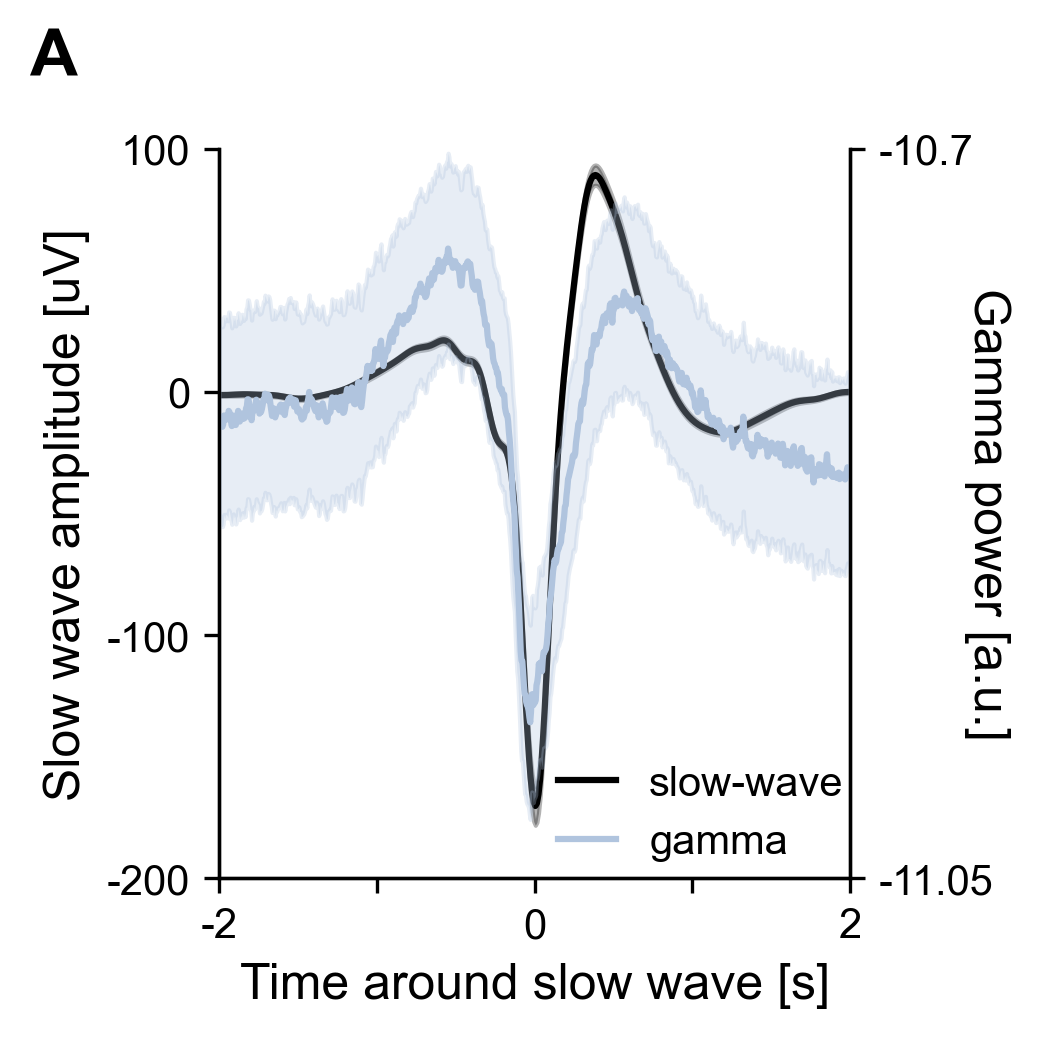

In [7]:
fig, ax = plt.subplots(
    figsize=plots._get_figsize_inches((8.5, 8.5)), dpi=300, layout="constrained"
)

# Plot SWs
t_sw = np.linspace(-2, 2, epo_sw_N3_mean.shape[0])
line_sw = ax.plot(t_sw, epo_sw_N3_mean * 1e6, color="k", lw=1.5, label="slow-wave")
ax.fill_between(
    t_sw,
    (epo_sw_N3_mean - epo_sw_N3_sem) * 1e6,
    (epo_sw_N3_mean + epo_sw_N3_sem) * 1e6,
    alpha=0.3,
    color="k",
)

# Plot gamma
ax2 = ax.twinx()
t_gamma = np.linspace(-2, 2, epo_gamma_N3_mean.shape[0])
line_gamma = ax2.plot(
    t_gamma, epo_gamma_N3_mean, color="lightsteelblue", lw=1.5, label="gamma"
)
ax2.fill_between(
    t_gamma,
    epo_gamma_N3_mean - epo_gamma_N3_sem,
    epo_gamma_N3_mean + epo_gamma_N3_sem,
    alpha=0.3,
    color="lightsteelblue",
)

# Plot parameters
plots._format_spines(ax, s_inv=["top"])
plots._format_spines(ax2, s_inv=["top"])
ax.set_xlim(-2, 2)
ax.set_xticks(
    [-2, -1, 0, 1, 2], labels=[-2, "", 0, "", 2], fontsize=plots.fsize.TICK_SIZE
)
ax.set_ylim(-200, 100)
ax.set_yticks(
    [-200, -100, 0, 100], labels=[-200, -100, 0, 100], fontsize=plots.fsize.TICK_SIZE
)
ax2.set_ylim(-11.05, -10.7)
ax2.set_yticks([-11.05, -10.7], labels=[-11.05, -10.7], fontsize=plots.fsize.TICK_SIZE)

ax.set_xlabel("Time around slow wave [s]", fontsize=plots.fsize.LABEL_SIZE)
ax.set_ylabel("Slow wave amplitude [uV]", fontsize=plots.fsize.LABEL_SIZE)
ax2.set_ylabel("Gamma power [a.u.]", fontsize=plots.fsize.LABEL_SIZE, rotation=-90)
lns = line_sw + line_gamma
ax.legend(
    lns,
    [l.get_label() for l in lns],
    fontsize=plots.fsize.TEXT_SIZE,
    frameon=False,
    loc=(0.51, 0.),  #"lower right",
    handlelength=1.4
)

# Annotate panel
ax.text(-0.3, 1.1, "A", transform=ax.transAxes, size=16, weight="bold")

plots.save_figure(fig, fig_path.joinpath(f"sw_average.svg"))
plt.show()

### B) Average increase around slow waves

In [4]:
cols_time = ["-2.0", "-1.5", "-1.0", "-0.5", "0.0", "0.5", "1.0", "1.5", "2.0"]

Load timescales for each channel:

In [5]:
# Read timescales values
df_timescales_sw = pd.read_csv(
    sw_tau_path.joinpath("timescales_sw_N3.csv"), index_col=0
)
# df_timescales_sw = df_timescales_sw[["pat"] + cols_time]
# df_timescales_sw_plot = df_timescales_sw_plot.groupby(["pat"]).mean()
df_timescales_sw_gamma = pd.read_csv(
    sw_tau_gamma_path.joinpath("timescales_sw_N3.csv"), index_col=0
)
# df_timescales_sw_gamma_plot = df_timescales_sw_gamma[cols_use]
# df_timescales_sw_gamma_plot = df_timescales_sw_gamma_plot.groupby(["pat"]).mean()

Load timescales per mmp area:

In [6]:
df_timescales_sw_mmp = [
    pd.read_csv(
        sw_tau_path.joinpath(f"timescales_sw_{t}_N3_mmp.csv"), index_col=0
    ).rename(columns={"0": t})
    for t in cols_time
]
df_timescales_sw_mmp = pd.concat(df_timescales_sw_mmp, axis=1)
df_timescales_sw_gamma_mmp = [
    pd.read_csv(
        sw_tau_gamma_path.joinpath(f"timescales_sw_{t}_N3_mmp.csv"), index_col=0
    ).rename(columns={"0": t})
    for t in cols_time
]
df_timescales_sw_gamma_mmp = pd.concat(df_timescales_sw_gamma_mmp, axis=1)

Absolute timescale changes related to SWs:

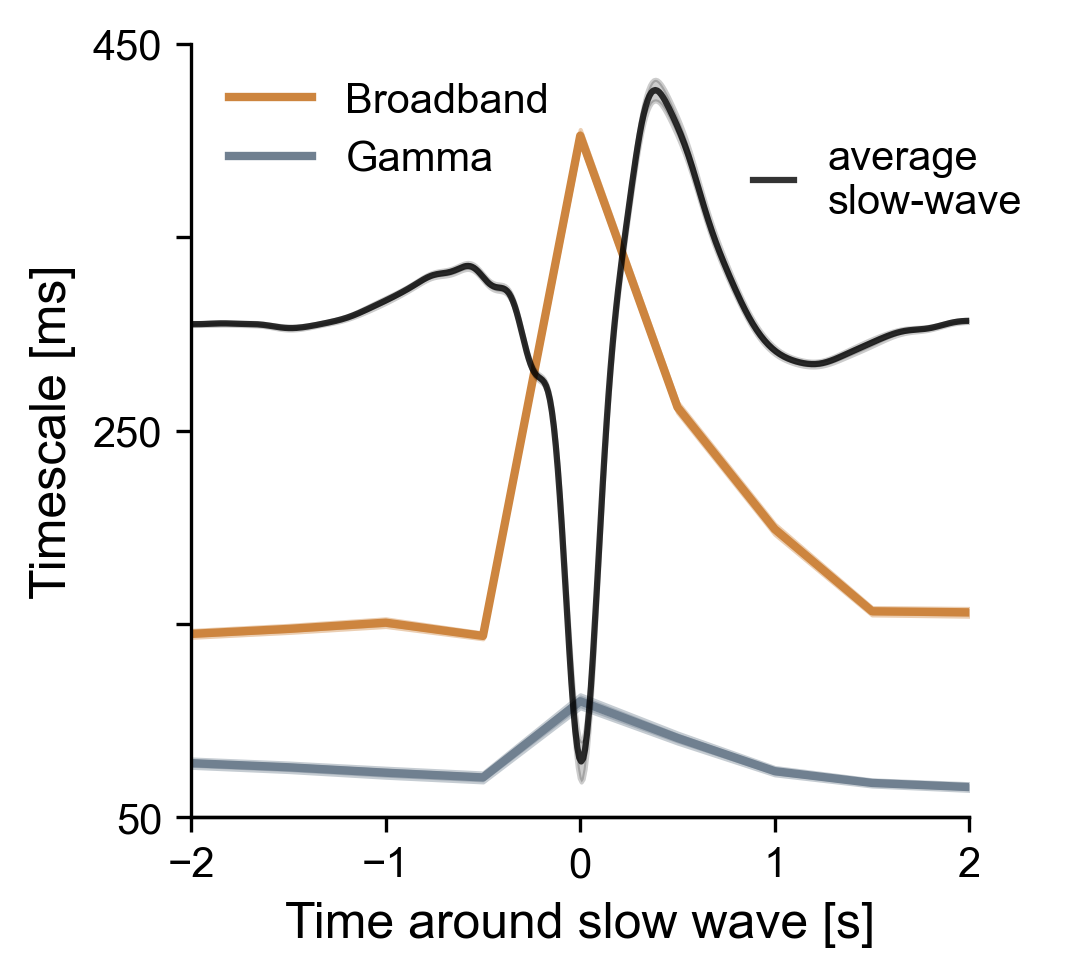

In [18]:
fig, ax = plt.subplots(1, 1, figsize=plots._get_figsize_inches((8.5, 8.5)), dpi=300)
ax2 = ax.twinx()
t = np.linspace(-2, 2, len(epo_sw_N3_mean))
ln1 = ax2.plot(t, epo_sw_N3_mean, lw=1.5, c="k", alpha=0.8, label="average\nslow-wave")
ax2.fill_between(
    t,
    epo_sw_N3_mean - epo_sw_N3_sem,
    epo_sw_N3_mean + epo_sw_N3_sem,
    alpha=0.2,
    color="k",
)
ln2 = ax.plot(
    df_timescales_sw_mmp.columns.astype(float),
    df_timescales_sw_mmp.mean(),
    lw=2,
    c="peru",
    label="Broadband",
)
ax.fill_between(
    df_timescales_sw_mmp.columns.astype(float),
    df_timescales_sw_mmp.mean() - df_timescales_sw_mmp.sem(),
    df_timescales_sw_mmp.mean() + df_timescales_sw_mmp.sem(),
    alpha=0.4,
    color="peru",
)
ln3 = ax.plot(
    df_timescales_sw_gamma_mmp.columns.astype(float),
    df_timescales_sw_gamma_mmp.mean(),
    lw=2,
    c="slategrey",
    label="Gamma",
)
ax.fill_between(
    df_timescales_sw_gamma_mmp.columns.astype(float),
    df_timescales_sw_gamma_mmp.mean() - df_timescales_sw_gamma_mmp.sem(),
    df_timescales_sw_gamma_mmp.mean() + df_timescales_sw_gamma_mmp.sem(),
    alpha=0.4,
    color="slategrey",
)
plots._format_spines(ax, ["top", "right"])
plots._format_spines(ax2, ["top", "right", "left"])
ax2.set_yticks([], labels=[], fontsize=0)
ax2.set_ylabel("", fontsize=0)
ax.set_ylim(50, 450)
ax.set_yticks(
    [50, 150, 250, 350, 450],
    labels=[50, "", 250, "", 450],
    fontsize=plots.fsize.TICK_SIZE,
)
ax.set_ylabel("Timescale [ms]", fontsize=plots.fsize.LABEL_SIZE)
ax.set_xlim(-2, 2)
ax.set_xlabel("Time around slow wave [s]", fontsize=plots.fsize.LABEL_SIZE)
lns = ln1 + ln2 + ln3
labs = [l.get_label() for l in lns]
ax.legend(frameon=False, loc="upper left")
ax2.legend(frameon=False, loc=(0.7,0.75), handlelength=1.)

# Save figure
plots.save_figure(fig, fig_path.joinpath(f"sw_tau.svg"))
plt.show()

Normalized to baseline value:

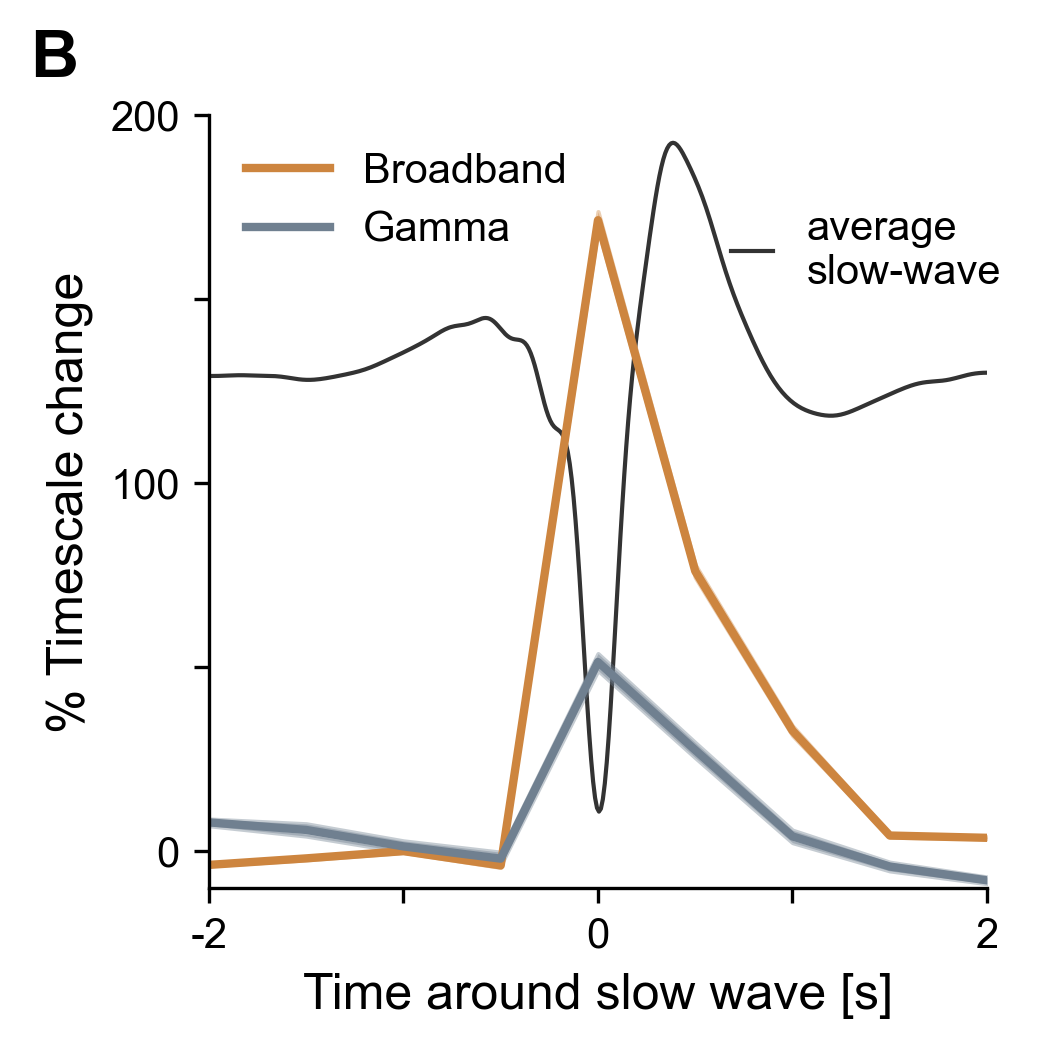

In [22]:
fig, ax = plt.subplots(1, 1, figsize=plots._get_figsize_inches((8.5, 8.5)), dpi=300)

df_timescales_sw_base = (
    df_timescales_sw_mmp["-2.0"] + df_timescales_sw_mmp["2.0"]
) / 2
df_timescales_sw_norm = (
    df_timescales_sw_mmp.sub(df_timescales_sw_base, axis=0).div(
        df_timescales_sw_base, axis=0
    )
    * 100
)
df_timescales_sw_gamma_base = (
    df_timescales_sw_gamma_mmp["-2.0"] + df_timescales_sw_gamma_mmp["2.0"]
) / 2
df_timescales_sw_gamma_norm = (
    df_timescales_sw_gamma_mmp.sub(df_timescales_sw_gamma_base, axis=0).div(
        df_timescales_sw_gamma_base, axis=0
    )
    * 100
)

# Plot change in broadband
ax.plot(
    df_timescales_sw_norm.columns.astype(float),
    df_timescales_sw_norm.mean(),
    lw=2,
    c="peru",
    label="Broadband",
)
ax.fill_between(
    df_timescales_sw_norm.columns.astype(float),
    df_timescales_sw_norm.mean() - df_timescales_sw_norm.sem(),
    df_timescales_sw_norm.mean() + df_timescales_sw_norm.sem(),
    alpha=0.4,
    color="peru",
)

# Plot change in gamma
ax.plot(
    df_timescales_sw_gamma_norm.columns.astype(float),
    df_timescales_sw_gamma_norm.mean(),
    lw=2,
    c="slategrey",
    label="Gamma",
)
ax.fill_between(
    df_timescales_sw_gamma_norm.columns.astype(float),
    df_timescales_sw_gamma_norm.mean() - df_timescales_sw_gamma_norm.sem(),
    df_timescales_sw_gamma_norm.mean() + df_timescales_sw_gamma_norm.sem(),
    alpha=0.4,
    color="slategrey",
)

# Plot average SW
ax2 = ax.twinx()
t = np.linspace(-2, 2, len(epo_sw_N3_mean))
ax2.plot(t, epo_sw_N3_mean, lw=1., c="k", alpha=0.8, label="average\nslow-wave")

ax2.set_ylim(-200 * 1e-6, 100 * 1e-6)
plots._format_spines(ax2, ["top", "right", "left", "bottom"])
ax2.set_yticks([], labels=[], fontsize=0)
ax2.set_ylabel("", fontsize=0)

ax.set_ylim(-10, 200)
ax.set_yticks(np.arange(0, 201, 50), labels=[0, "", 100, "", 200], fontsize=plots.fsize.TICK_SIZE)
ax.set_ylabel("% Timescale change", fontsize=plots.fsize.LABEL_SIZE)
ax.set_xlim(-2., 2.)
ax.set_xticks(
    [-2, -1, 0, 1, 2], labels=[-2, "", 0, "", 2], fontsize=plots.fsize.TICK_SIZE
)
plots._format_spines(ax, ["top", "right"]) #, s_bounds={"bottom": (-2, 2), "left": (0, 200)})
ax.set_xlabel("Time around slow wave [s]", fontsize=plots.fsize.LABEL_SIZE)
ax.legend(frameon=False, loc="upper left")
ax2.legend(frameon=False, loc=(0.65,0.75), handlelength=1.)

# Annotate panel
ax.text(-0.23, 1.05, "B", transform=ax.transAxes, size=16, weight="bold")

# Set average SW below other traces
ax.set_zorder(1)  # default zorder is 0 for ax and ax2
ax.patch.set_visible(False)

# Save figure
plots.save_figure(fig, fig_path.joinpath(f"sw_tau_norm.svg"))
plt.show()

In [34]:
df_timescales_sw_gamma_norm.mean()

-2.0     7.870109
-1.5     5.823082
-1.0     1.339283
-0.5    -1.977730
0.0     51.449512
0.5     27.502668
1.0      4.065143
1.5     -4.123730
2.0     -7.870109
dtype: float64

#### Control for timescale increase

We compute the % of electrodes showing the pattern of increased timescales relative to baseline for broadband and gamma.

In [22]:
prop_bb = df_timescales_sw[
    df_timescales_sw["0.0"] < (df_timescales_sw["-2.0"] + df_timescales_sw["2.0"]) / 2
].shape[0] / df_timescales_sw.shape[0]
print(f"% electrodes not following the pattern for broadband: {prop_bb * 100:.2f}")

prop_gamma = df_timescales_sw_gamma[
    df_timescales_sw_gamma["0.0"] < (df_timescales_sw_gamma["-2.0"] + df_timescales_sw_gamma["2.0"]) / 2
].shape[0] / df_timescales_sw_gamma.shape[0]
print(f"% electrodes not following the pattern for gamma: {prop_gamma * 100:.2f}")

% electrodes not following the pattern for broadband: 0.34
% electrodes not following the pattern for gamma: 34.81


### C) Correlation with timescales

Load centroids coordinates of the parcellation (for spin permutation):

In [4]:
map_coords = pd.read_csv(
    data_path.joinpath("Data", "Parcellation", "mmp_centroids_coords.csv"), index_col=0
)

#### N3 stage

Generating 1000 permutations...
Generating 1000 permutations...


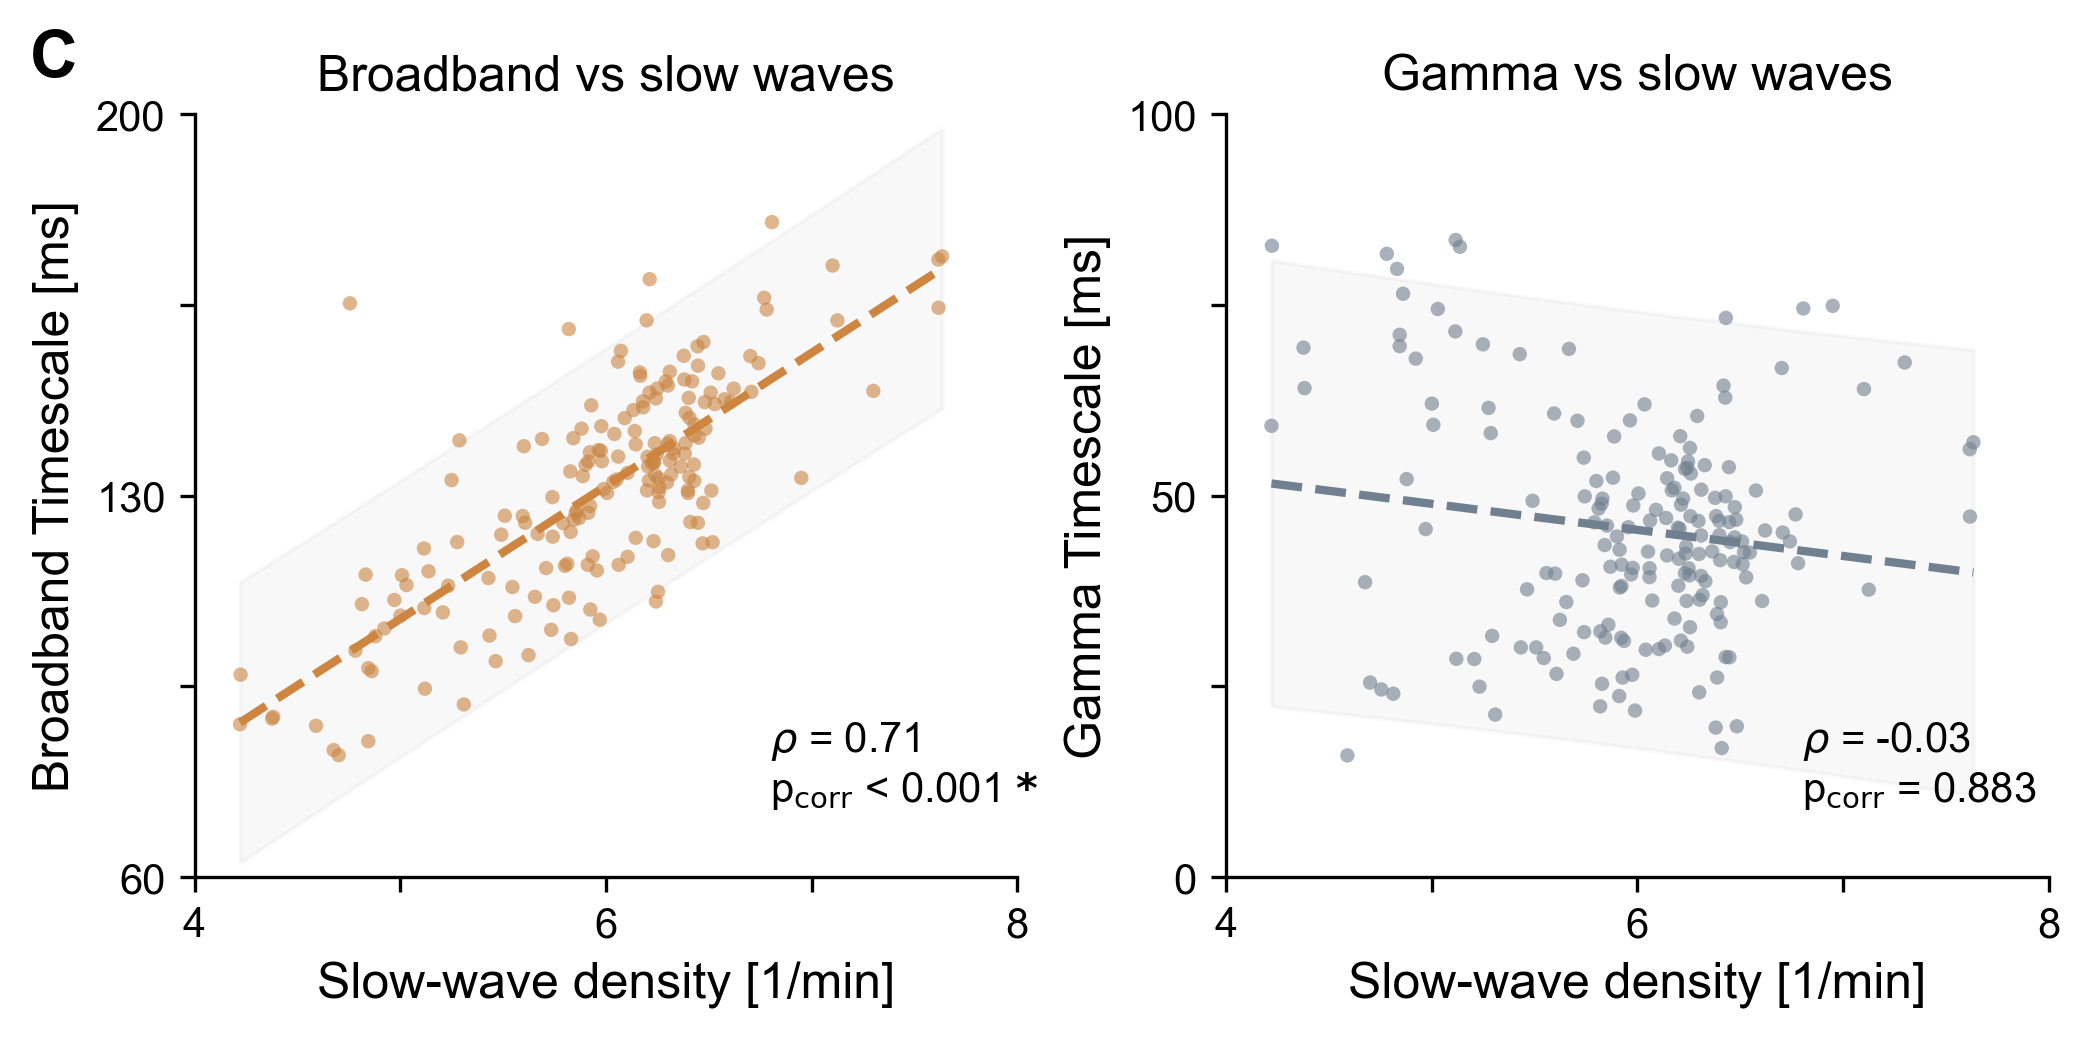

In [5]:
colors = ["peru", "slategrey"]
xlabel = "Slow-wave density [1/min]"
ylabels = ["Broadband Timescale [ms]", "Gamma Timescale [ms]"]
titles = ["Broadband vs slow waves", "Gamma vs slow waves"]
xlims = (4, 8)
xticks = [4, 5, 6, 7, 8]
xtick_labels = [4, "", 6, "", 8]
ylims = ((60, 200), (0, 100))
yticks = (np.arange(60, 201, 35), np.arange(0, 101, 25))
ytick_labels = ([60, "", 130, "", 200], [0, "", 50, "", 100])

fig, axs = plt.subplots(
    1,
    2,
    figsize=plots._get_figsize_inches((17.4, 8.5)),
    dpi=300,
    layout="constrained",
)

for i, df_timescales in enumerate(
    [df_timescales_stages["N3"], df_timescales_stages_gamma["N3"]]
):
    # Import dataframe
    df_tau = df_timescales.copy()
    df_sw = df_density_stages["N3"].copy()

    # Get data
    x = df_sw.to_numpy().squeeze()
    y = df_tau.loc[df_sw.index].to_numpy().squeeze()

    # Get correlation values
    rho, p_corr = utils.get_pcorr(x, y, map_coords, method="vasa", corr_type=corr_type)
    rho_boot = utils.get_rho_boot(x, y, corr_type=corr_type)

    # Plot
    axs[i] = plots.plot_corr(
        axs[i],
        x,
        y,
        rho,
        p_corr,
        markersize=12,
        xy_annot=(0.7, 0.1),
        color=colors[i],
        xlabel=xlabel,
        ylabel=ylabels[i],
        xlims=xlims,
        ylims=ylims[i],
        title=titles[i],
    )

    # Set ticks
    axs[i].set_xticks(xticks, labels=xtick_labels, fontsize=plots.fsize.TICK_SIZE)
    axs[i].set_yticks(yticks[i], labels=ytick_labels[i], fontsize=plots.fsize.TICK_SIZE)

# Annotate panel
axs[0].text(-0.2, 1.05, "C", transform=axs[0].transAxes, size=16, weight="bold")

# Save figure
plots.save_figure(fig, fig_path.joinpath(f"sw_tau_corr.svg"))
plt.show()

### Check correspondace with 1-minute dataset

LinregressResult(slope=0.9233279139143021, intercept=23.439124719547408, rvalue=0.8146849533382629, pvalue=5.511595173323107e-44, stderr=0.04926202152303371, intercept_stderr=6.5322439571755)


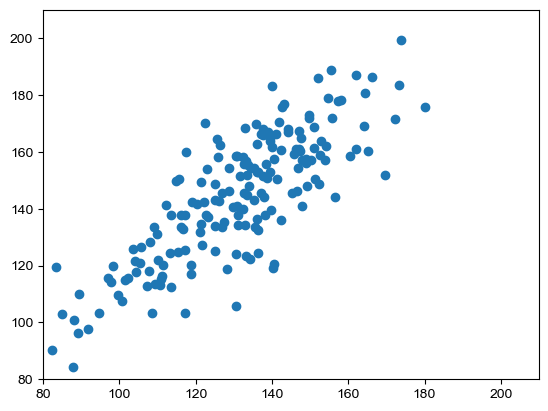

In [16]:
from scipy.stats import linregress

df_timescales_1m = pd.read_csv(data_path.joinpath("Results", "timescales_broadband", "tau_N3_mmp.csv"), index_col=0)
res = linregress(df_timescales_stages["N3"].to_numpy().squeeze(), df_timescales_1m.to_numpy().squeeze())
print(res)
plt.figure()
plt.plot(df_timescales_stages["N3"], df_timescales_1m, "o")
plt.xlim(80, 210)
plt.ylim(80, 210)
plt.show()

LinregressResult(slope=0.6775912846303365, intercept=42.58853972283684, rvalue=0.7494743391693593, pvalue=1.0378200204898801e-33, stderr=0.044862238397638046, intercept_stderr=6.838768650917812)


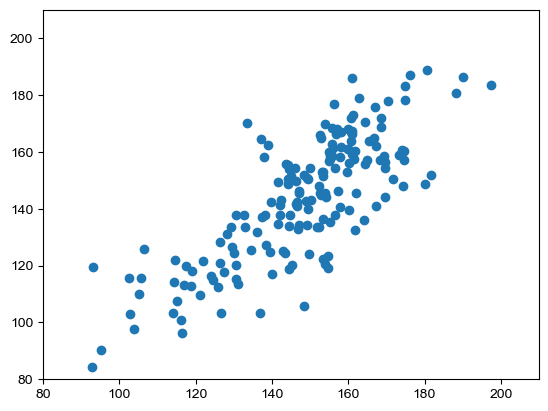

In [20]:
x = ((df_timescales_sw_mmp["-2.0"] + df_timescales_sw_mmp["2.0"]) / 2).to_numpy().squeeze()
res = linregress(x, df_timescales_1m.to_numpy().squeeze())
print(res)
plt.figure()
plt.plot(x, df_timescales_1m, "o")
plt.xlim(80, 210)
plt.ylim(80, 210)
plt.show()

### S0) Correlate with baseline or peak timescales

Generating 1000 permutations...
Generating 1000 permutations...


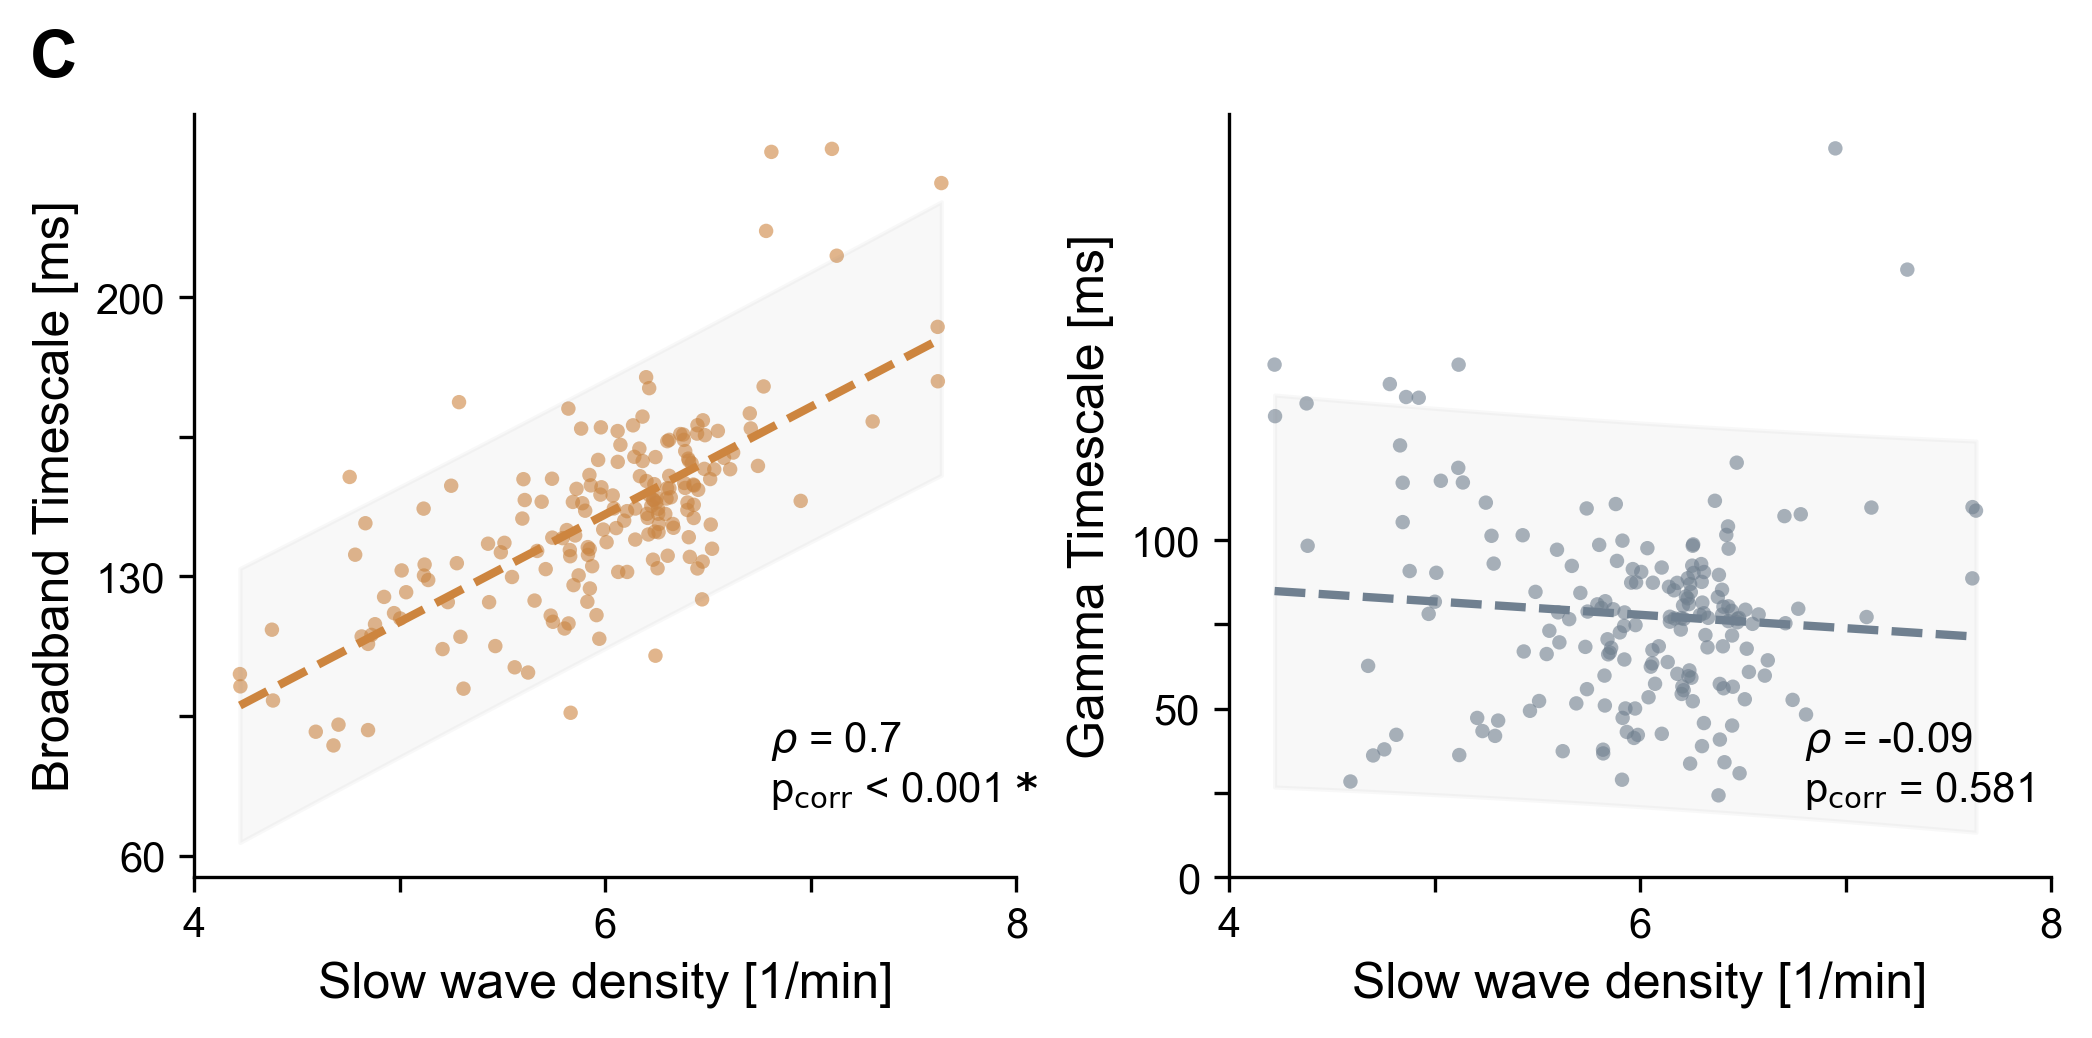

In [23]:
colors = ["peru", "slategrey"]
xlabel = "Slow wave density [1/min]"
ylabels = ["Broadband Timescale [ms]", "Gamma Timescale [ms]"]
xlims = (4, 8)
xticks = [4, 5, 6, 7, 8]
xtick_labels = [4, "", 6, "", 8]
ylims = ((60, 200), (0, 100))
yticks = (np.arange(60, 201, 35), np.arange(0, 101, 25))
ytick_labels = ([60, "", 130, "", 200], [0, "", 50, "", 100])

fig, axs = plt.subplots(
    1,
    2,
    figsize=plots._get_figsize_inches((17.4, 8.5)),
    dpi=300,
    layout="constrained",
)

for i, df_timescales in enumerate(
    [df_timescales_sw_plot["-2.0"], df_timescales_sw_gamma_plot["-2.0"]]
):  # [df_timescales_stages["N3"], df_timescales_stages_gamma["N3"]]):
    # Import dataframe
    df_tau = df_timescales.copy()
    df_sw = df_density_stages["N3"].copy()

    # Get data
    x = df_sw.to_numpy().squeeze()
    y = df_tau.loc[df_sw.index].to_numpy().squeeze()

    # Get correlation values
    rho, p_corr = utils.get_pcorr(x, y, map_coords, method="vasa", corr_type=corr_type)
    rho_boot = utils.get_rho_boot(x, y, corr_type=corr_type)

    # Plot
    axs[i] = plots.plot_corr(
        axs[i],
        x,
        y,
        rho,
        p_corr,
        markersize=12,
        xy_annot=(0.7, 0.1),
        color=colors[i],
        xlabel=xlabel,
        ylabel=ylabels[i],
        xlims=xlims,
        # ylims=ylims[i],
    )

    # Set ticks
    axs[i].set_xticks(xticks, labels=xtick_labels, fontsize=plots.fsize.TICK_SIZE)
    axs[i].set_yticks(yticks[i], labels=ytick_labels[i], fontsize=plots.fsize.TICK_SIZE)

# Annotate panel
axs[0].text(-0.2, 1.05, "C", transform=axs[0].transAxes, size=16, weight="bold")

# Save figure
# plots.save_figure(fig, fig_path.joinpath(f"sw_tau_corr.svg"))
plt.show()

As expected, very similar to previous plot.

Generating 1000 permutations...
Generating 1000 permutations...


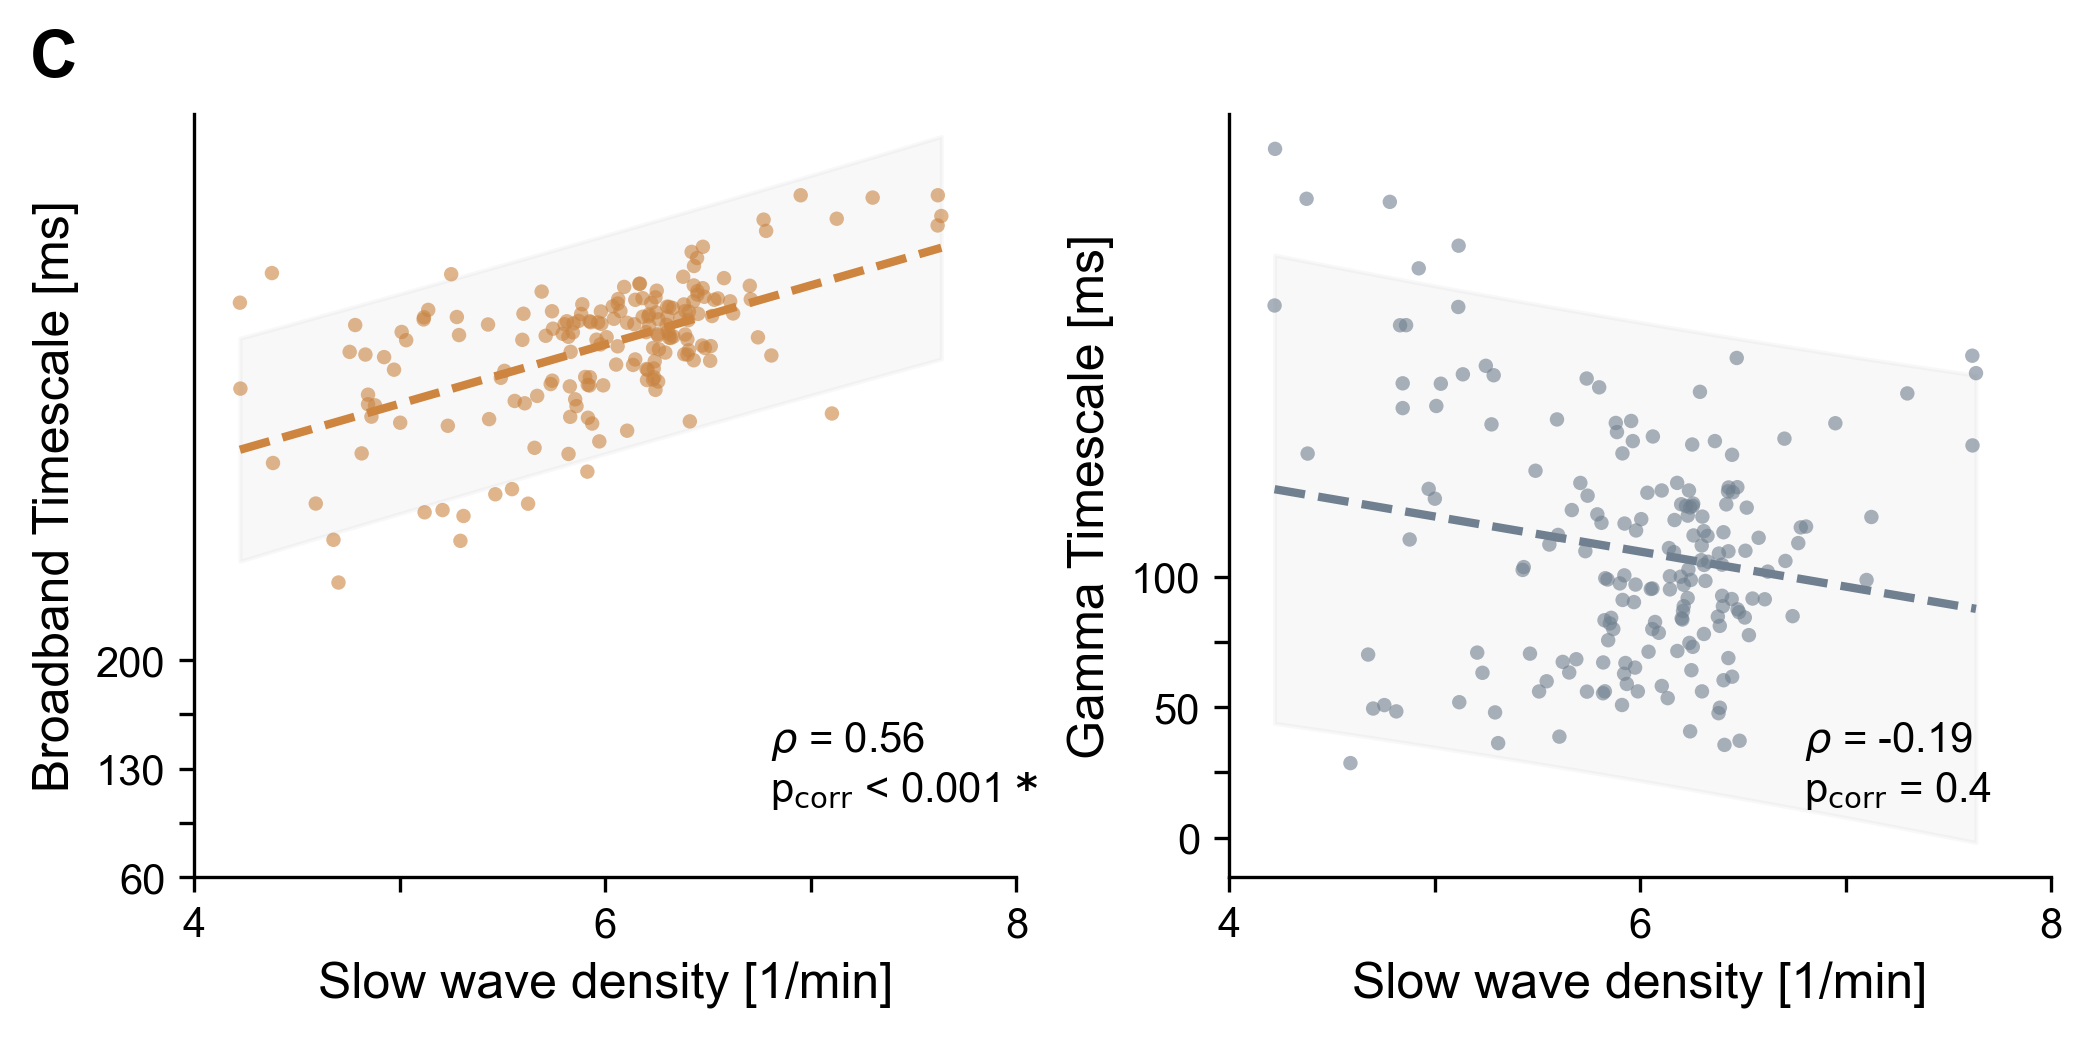

In [24]:
colors = ["peru", "slategrey"]
xlabel = "Slow wave density [1/min]"
ylabels = ["Broadband Timescale [ms]", "Gamma Timescale [ms]"]
xlims = (4, 8)
xticks = [4, 5, 6, 7, 8]
xtick_labels = [4, "", 6, "", 8]
ylims = ((60, 200), (0, 100))
yticks = (np.arange(60, 201, 35), np.arange(0, 101, 25))
ytick_labels = ([60, "", 130, "", 200], [0, "", 50, "", 100])

fig, axs = plt.subplots(
    1,
    2,
    figsize=plots._get_figsize_inches((17.4, 8.5)),
    dpi=300,
    layout="constrained",
)

for i, df_timescales in enumerate(
    [df_timescales_sw_plot["0.0"], df_timescales_sw_gamma_plot["0.0"]]
):  # [df_timescales_stages["N3"], df_timescales_stages_gamma["N3"]]):
    # Import dataframe
    df_tau = df_timescales.copy()
    df_sw = df_density_stages["N3"].copy()

    # Get data
    x = df_sw.to_numpy().squeeze()
    y = df_tau.loc[df_sw.index].to_numpy().squeeze()

    # Get correlation values
    rho, p_corr = utils.get_pcorr(x, y, map_coords, method="vasa", corr_type=corr_type)
    rho_boot = utils.get_rho_boot(x, y, corr_type=corr_type)

    # Plot
    axs[i] = plots.plot_corr(
        axs[i],
        x,
        y,
        rho,
        p_corr,
        markersize=12,
        xy_annot=(0.7, 0.1),
        color=colors[i],
        xlabel=xlabel,
        ylabel=ylabels[i],
        xlims=xlims,
        # ylims=ylims[i],
    )

    # Set ticks
    axs[i].set_xticks(xticks, labels=xtick_labels, fontsize=plots.fsize.TICK_SIZE)
    axs[i].set_yticks(yticks[i], labels=ytick_labels[i], fontsize=plots.fsize.TICK_SIZE)

# Annotate panel
axs[0].text(-0.2, 1.05, "C", transform=axs[0].transAxes, size=16, weight="bold")

# Save figure
# plots.save_figure(fig, fig_path.joinpath(f"sw_tau_corr.svg"))
plt.show()

This shows more variability, but the picture remains more or less the same.

### S1) Correlate SW maps to T1w/T2w

In [6]:
df_struct = pd.read_csv(
    data_path.joinpath("Data", "Raw", "df_structural_avg.csv"), index_col=0
)

Generating 1000 permutations...
Generating 1000 permutations...


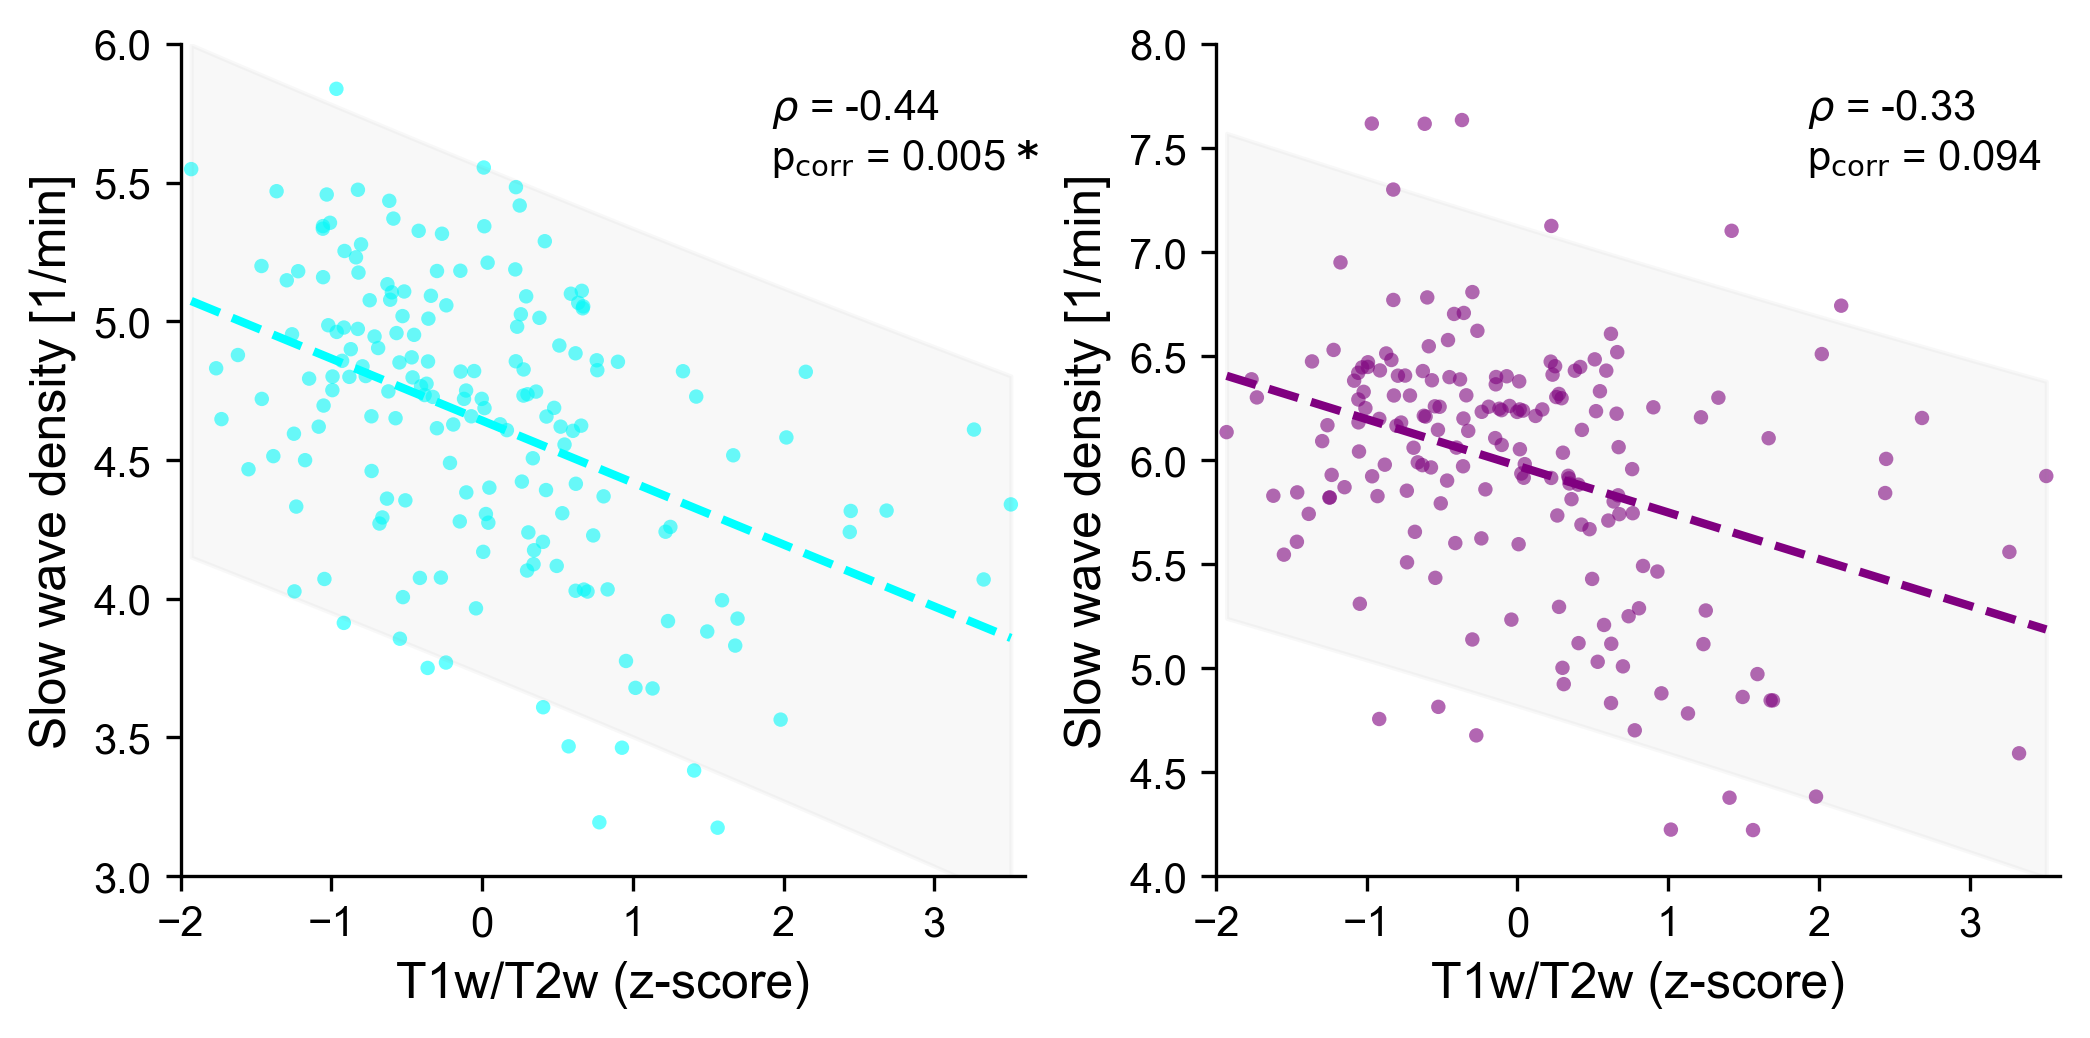

In [7]:
xlims = (-2, 3.6)
ylabels = {
    "total": "Slow wave density [1/min]",
    "local": "Slow wave density (local) [1/min]",
    "global": "Slow wave density (global) [1/min]",
}
ylims_stages = {
    "total": {"N2": (3.0, 6.0), "N3": (4, 8)},
    "local": {"N2": (1, 3.5), "N3": (1.5, 5)},
    "global": {"N2": (1, 4.5), "N3": (1.5, 4.5)},
}
for cond, df_metric in zip(
    ["total"],  # , "local", "global"],
    [df_density_stages],  # , df_density_stages_local, df_density_stages_global],
):
    fig, axs = plt.subplots(
        1,
        len(stages),
        figsize=plots._get_figsize_inches((17.4, 8.5)),
        dpi=300,
        layout="constrained",
    )
    if not isinstance(axs, np.ndarray):
        axs = np.array(axs).reshape(
            1,
        )

    rhos, p_corrs, rhos_boot = {}, {}, {}
    for i, stage in enumerate(stages):
        # Import dataframe
        df_sw = df_metric[stage].copy()
        # Get data
        x = zscore(df_struct["T1T2"], ddof=1).to_numpy()
        y = df_sw.loc[df_struct.index].to_numpy().squeeze()
        # Get correlation values
        rho, p_corr = utils.get_pcorr(
            x, y, map_coords, method="vasa", corr_type=corr_type
        )
        rho_boot = utils.get_rho_boot(x, y, corr_type=corr_type)
        rhos[stage] = rho
        p_corrs[stage] = p_corr
        rhos_boot[stage] = rho_boot
        # Plot
        axs[i] = plots.plot_corr(
            axs[i],
            x,
            y,
            rho,
            p_corr,
            markersize=12,
            color=stage_colors[stage],
            xlabel="T1w/T2w (z-score)",
            ylabel=ylabels[cond],
            xlims=(-2, 3.6),
            ylims=ylims_stages[cond][stage],
        )
    # Save figure
    plots.save_figure(fig, fig_path.joinpath(f"sw_struct_corr_{cond}.svg"))

    plt.show()

Recompute SW-timescales correlation taking into account the structural correlation:

In [8]:
import pingouin

# For broadband
data = (
    df_timescales_stages["N3"]
    .rename(columns={"0": "timescale"})
    .join(df_density_stages["N3"].rename(columns={"0": "sw_density"}))
)
data["struct"] = zscore(df_struct["T1T2"], ddof=1)
stats = pingouin.partial_corr(
    data, x="sw_density", y="timescale", covar="struct", method=corr_type
)
print("Broadband:", stats)

# For gamma
data = (
    df_timescales_stages_gamma["N3"]
    .rename(columns={"0": "timescale"})
    .join(df_density_stages["N3"].rename(columns={"0": "sw_density"}))
)
data["struct"] = zscore(df_struct["T1T2"], ddof=1)
stats = pingouin.partial_corr(
    data, x="sw_density", y="timescale", covar="struct", method=corr_type
)
print("Gamma:", stats)

Broadband:             n         r         CI95%         p-val
spearman  180  0.662756  [0.57, 0.74]  5.240537e-24
Gamma:             n         r          CI95%     p-val
spearman  180  0.068736  [-0.08, 0.21]  0.360581


We have basically the same results when taking into account the structural gradient, so we can conclude that the relationship of timescales - SW density is not driven by the structural gradient.

### S2) Plot of parcellated brain areas

#### "Total" SWs density

In [29]:
minmax_stages = {"N2": (3.5, 5.5), "N3": (4.6, 7.1)}

# Loop through stages
for stage in stages:

    fig, ax = plots.plot_parcellated_metric(
        df_density_stages[stage].to_numpy().squeeze(),
        parc_labels,
        subjects_dir,
        labels_mne,
        log_scale=False,
        minmax=minmax_stages[stage],
        title=title_dict[stage],
        cmap="viridis",
        label="Slow waves / min",
        cbar_format="0f",
    )

    fig.savefig(
        fig_path.joinpath(f"sw_parc_{stage}.svg"),
        format="svg",
        transparent=True,
    )
    plt.close(fig)

Using pyvistaqt 3d backend.



c:\Users\ricca\anaconda3\envs\mni_analysis\lib\site-packages\pyvista\plotting\plotting\__init__.py:23: PyVistaDeprecationWarning: The `pyvista.plotting.plotting` module has been deprecated. `_ALL_PLOTTERS` is now imported as: `from pyvista.plotting import _ALL_PLOTTERS`.
  warnings.warn(


### S3) Changes within electrode / within area

In [36]:
df_tau_n3_all = pd.read_csv(tau_path.joinpath("tau_N3_mni.csv"), index_col=0)
df_tau_gamma_n3_all = pd.read_csv(
    tau_gamma_path.joinpath("tau_N3_mni.csv"), index_col=0
)
df_sw_n3_all = pd.read_csv(sw_path.joinpath("density_N3_mni.csv"), index_col=0)

print(df_tau_n3_all.shape, df_sw_n3_all.shape)

(1468, 12) (1468, 14)


LinregressResult(slope=32.411915211079865, intercept=-61.85372568127747, rvalue=0.6705087445720095, pvalue=2.6287117657962724e-192, stderr=0.9366548495661131, intercept_stderr=5.9295338949887935)


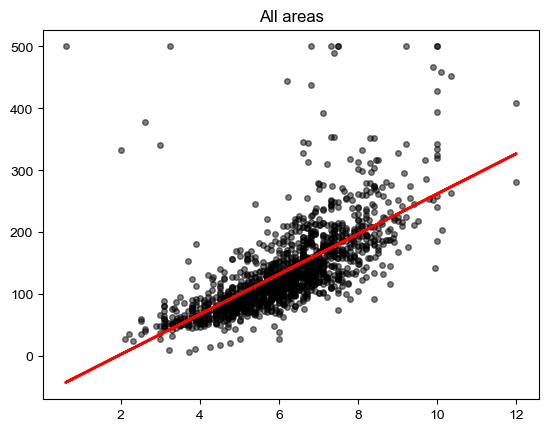

LinregressResult(slope=21.2006867803135, intercept=-0.08493261978001954, rvalue=0.8604865268968401, pvalue=5.628819127377838e-07, stderr=2.8797208739328384, intercept_stderr=13.68916047954768)


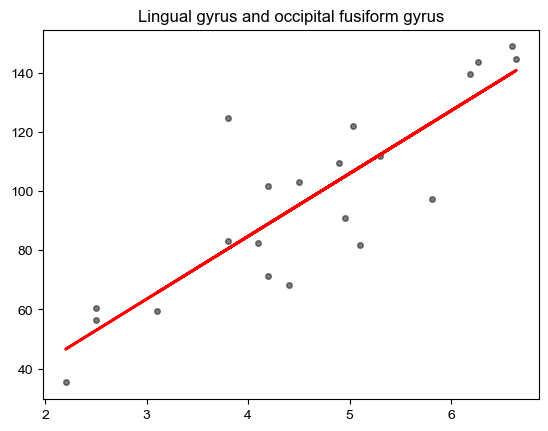

LinregressResult(slope=14.7104138471313, intercept=47.73814225304943, rvalue=0.4250452597991478, pvalue=0.0486177180132486, stderr=7.004963460003098, intercept_stderr=38.35836423856941)


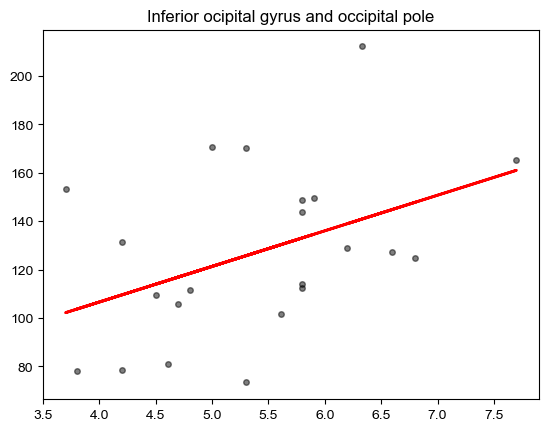

LinregressResult(slope=42.24290827094511, intercept=-72.2301416197656, rvalue=0.6363894885541699, pvalue=0.04789981231733483, stderr=18.10286756807865, intercept_stderr=69.2064837594626)


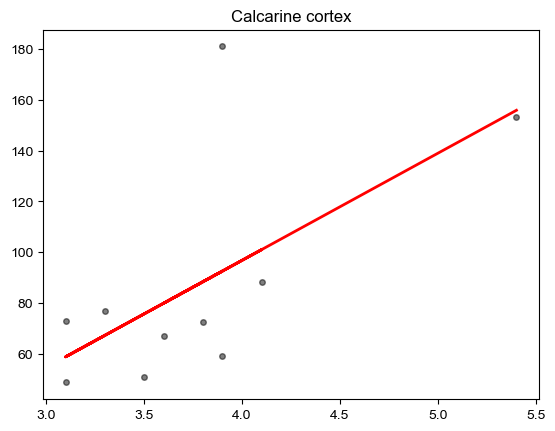

LinregressResult(slope=28.115082554857057, intercept=-29.99933152383585, rvalue=0.6399666456923602, pvalue=0.007583570304014033, stderr=9.022084317297951, intercept_stderr=54.18886459255946)


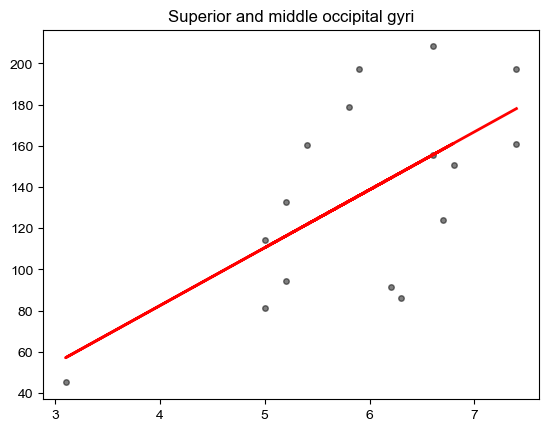

LinregressResult(slope=13.783674282472655, intercept=24.15032290593387, rvalue=0.613494557516469, pvalue=0.006772829066699838, stderr=4.4356355496830036, intercept_stderr=19.923636366115726)


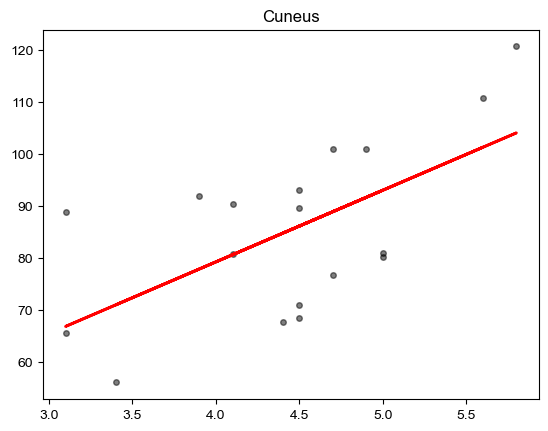

LinregressResult(slope=40.152313906802455, intercept=-114.16507546869207, rvalue=0.852861795529488, pvalue=2.0609850141783925e-11, stderr=4.155106261200473, intercept_stderr=26.549166368569566)


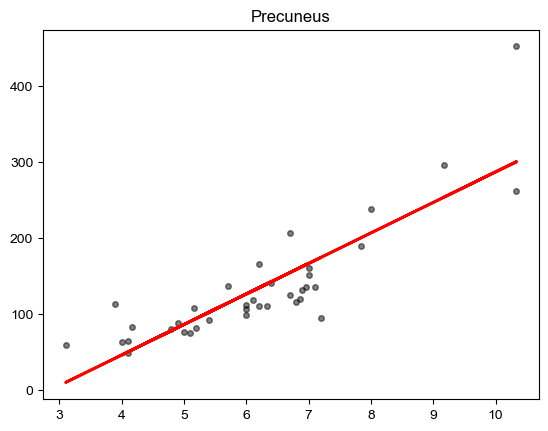

LinregressResult(slope=34.891236622128616, intercept=-85.62059250868452, rvalue=0.873570449002337, pvalue=2.947100688103125e-17, stderr=2.7491139224857886, intercept_stderr=19.37009280129886)


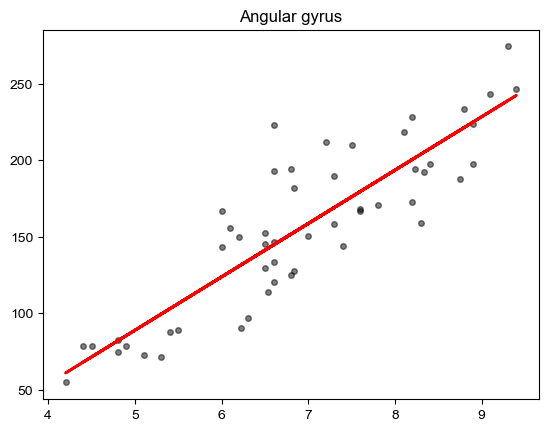

LinregressResult(slope=35.79761575764116, intercept=-98.24105612471863, rvalue=0.7909250269718923, pvalue=1.188027116333977e-07, stderr=5.142916966922692, intercept_stderr=34.27754892217684)


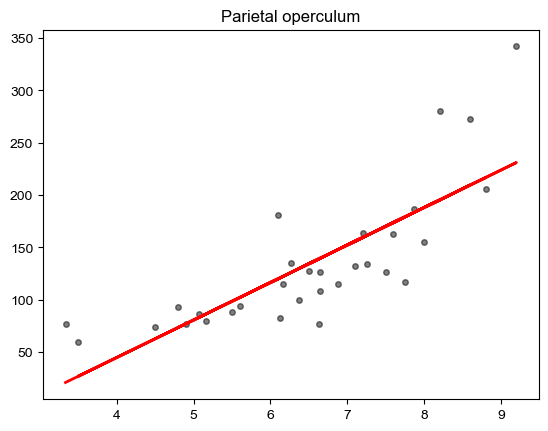

LinregressResult(slope=39.97655125767749, intercept=-121.27068868044321, rvalue=0.9033927174318491, pvalue=1.1423788420572676e-16, stderr=2.9635069244610373, intercept_stderr=21.003598527614496)


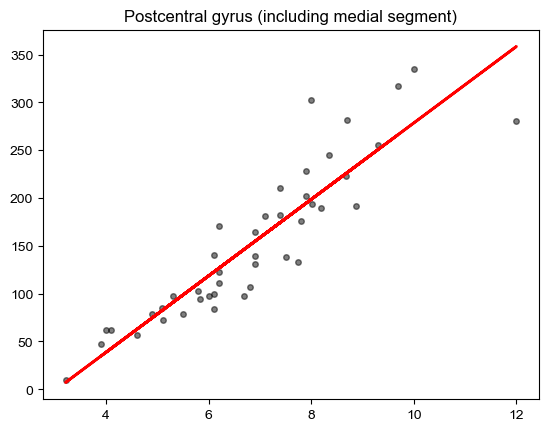

LinregressResult(slope=32.37627881815028, intercept=-71.04937340629706, rvalue=0.8040081394391025, pvalue=4.1612817528336946e-10, stderr=3.884301673725176, intercept_stderr=25.529016323939615)


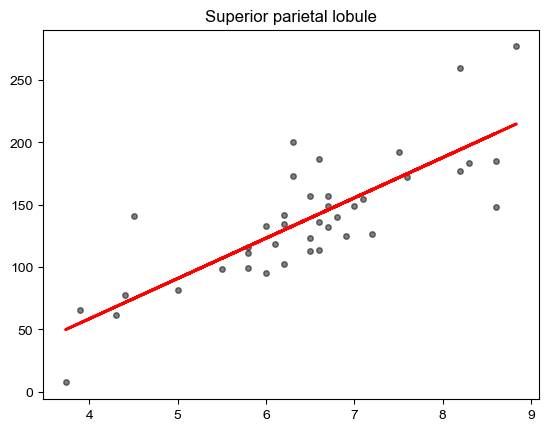

LinregressResult(slope=37.71995986056067, intercept=-96.03810715339336, rvalue=0.7911725252678999, pvalue=4.420861159422617e-15, stderr=3.6736034799679445, intercept_stderr=23.828042282824256)


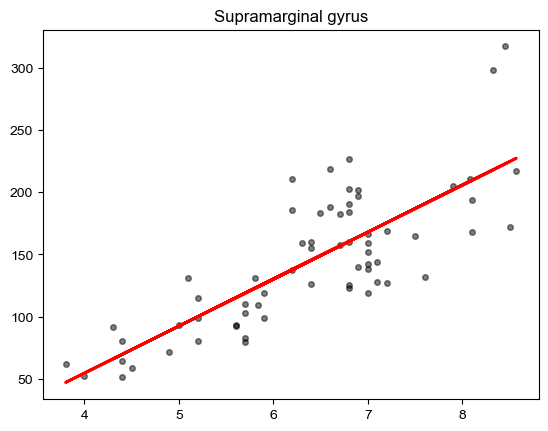

LinregressResult(slope=21.273062766578843, intercept=-10.394005263855604, rvalue=0.745176058562292, pvalue=1.923087820358357e-05, stderr=3.9696018369467567, intercept_stderr=24.085168560631182)


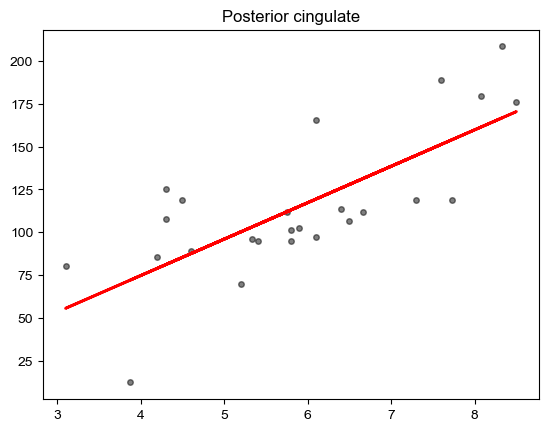

LinregressResult(slope=36.984941823232745, intercept=-77.90420235501031, rvalue=0.720641653707807, pvalue=8.037577527885947e-10, stderr=4.934349969561145, intercept_stderr=33.75711889658076)


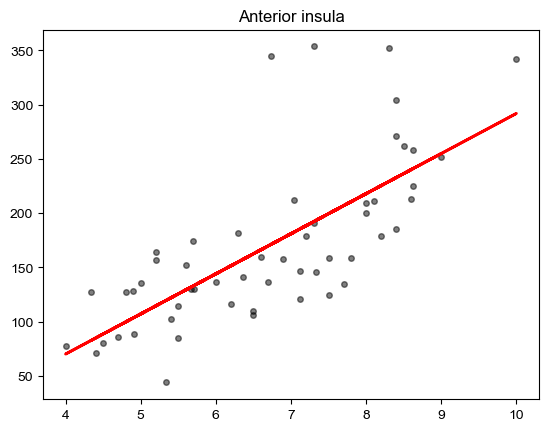

LinregressResult(slope=42.45033610961801, intercept=-76.02568288853718, rvalue=0.5365076865854536, pvalue=0.005694968945884093, stderr=13.922906396156666, intercept_stderr=94.00039286670227)


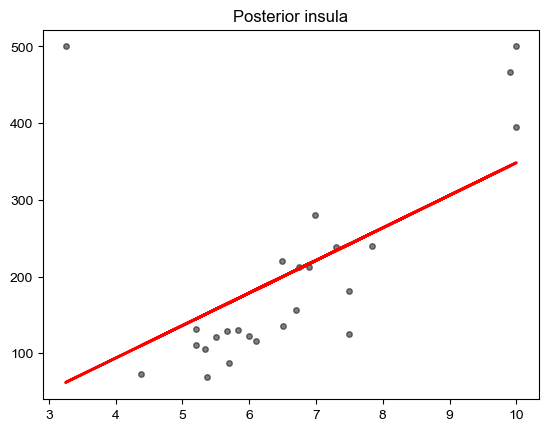

LinregressResult(slope=35.11813439287639, intercept=-90.63025883515203, rvalue=0.7062199474280481, pvalue=9.031139042987058e-06, stderr=6.5376417279997145, intercept_stderr=36.93110814340725)


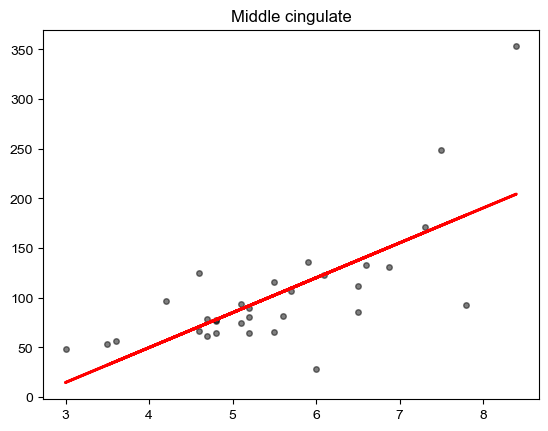

LinregressResult(slope=14.040550595434025, intercept=34.80093743569408, rvalue=0.34797318566483126, pvalue=0.0013581599203196485, stderr=4.229282749523707, intercept_stderr=25.970075902112114)


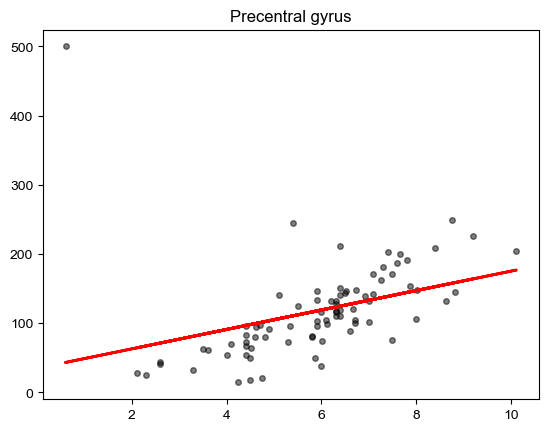

LinregressResult(slope=28.23508724027137, intercept=-49.42908275887328, rvalue=0.646590139471721, pvalue=1.5353481196879774e-05, stderr=5.630644663800486, intercept_stderr=32.96284709615599)


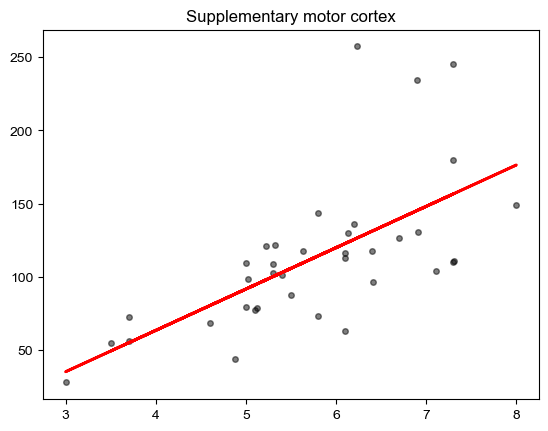

LinregressResult(slope=43.00993718103191, intercept=-128.07227457435917, rvalue=0.8040323845241601, pvalue=1.7095361339721965e-11, stderr=4.794940774923307, intercept_stderr=30.603829404710655)


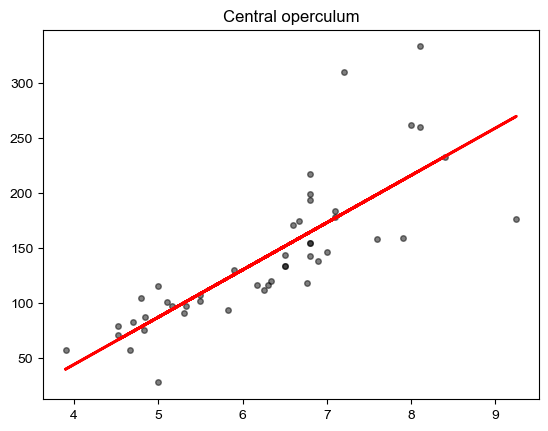

LinregressResult(slope=32.218506134001295, intercept=-70.06307306232819, rvalue=0.7882710003861872, pvalue=2.3139875901051384e-07, stderr=4.7528890253633636, intercept_stderr=33.10376545527559)


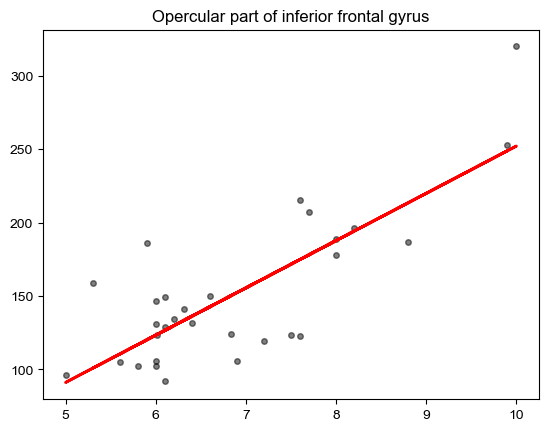

LinregressResult(slope=41.40538956666704, intercept=-129.7818559741198, rvalue=0.7838656743622354, pvalue=5.858054310025372e-06, stderr=6.99273120673267, intercept_stderr=50.9955856120105)


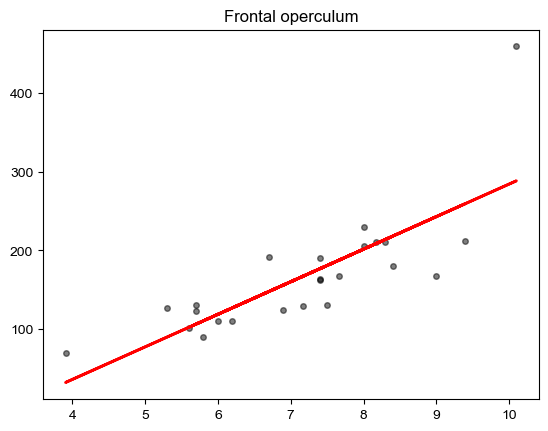

LinregressResult(slope=30.782076783499484, intercept=-59.76609232916081, rvalue=0.7202475308450698, pvalue=1.1038475307995542e-07, stderr=4.747514188097714, intercept_stderr=29.632198140909114)


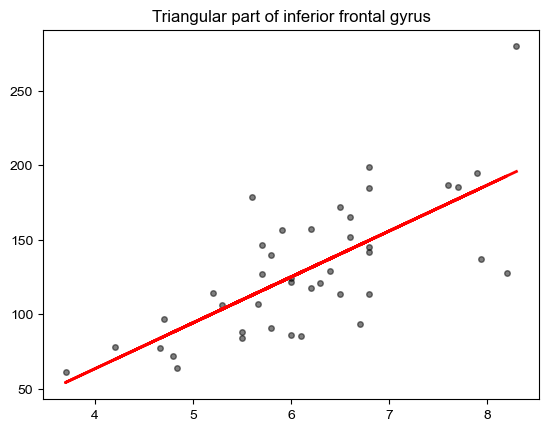

LinregressResult(slope=29.32555222396264, intercept=-56.25700254358793, rvalue=0.6836530661276055, pvalue=7.430859922249257e-22, stderr=2.582021672429556, intercept_stderr=16.674887558214564)


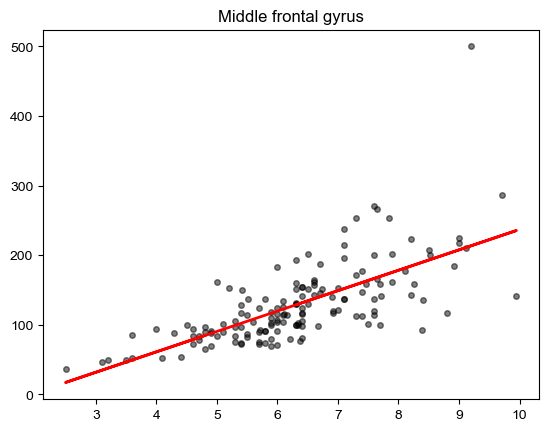

LinregressResult(slope=31.838604801716244, intercept=-55.26353210593042, rvalue=0.8024097458188127, pvalue=5.6705735287566484e-08, stderr=4.397120404996345, intercept_stderr=24.399004253344586)


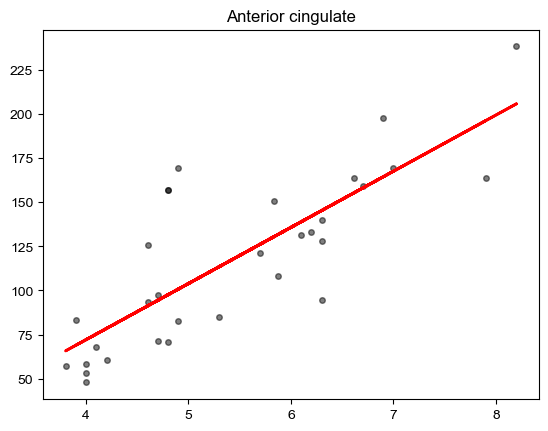

LinregressResult(slope=48.0415077930772, intercept=-154.5775694305002, rvalue=0.7623432690410159, pvalue=0.0005961257395284521, stderr=10.899895969047488, intercept_stderr=71.69927355222474)


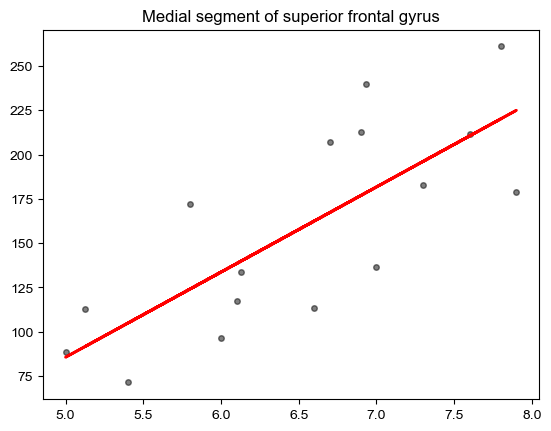

LinregressResult(slope=29.34127931865548, intercept=-45.36743471751771, rvalue=0.6798012594860643, pvalue=7.712723259029103e-12, stderr=3.631023382703641, intercept_stderr=23.32137019736)


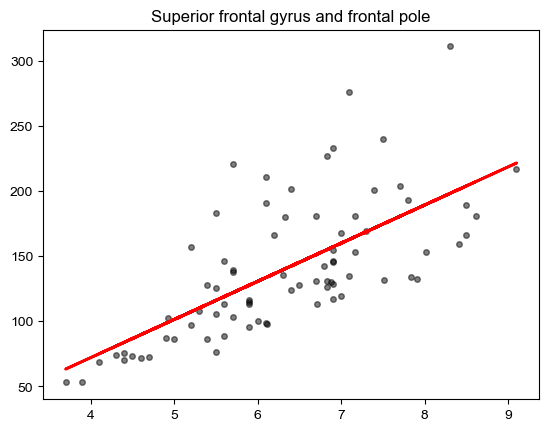

LinregressResult(slope=37.87030991177714, intercept=-87.29517443135992, rvalue=0.901171633268982, pvalue=2.603682125377246e-05, stderr=5.492201669413108, intercept_stderr=36.186034460317906)


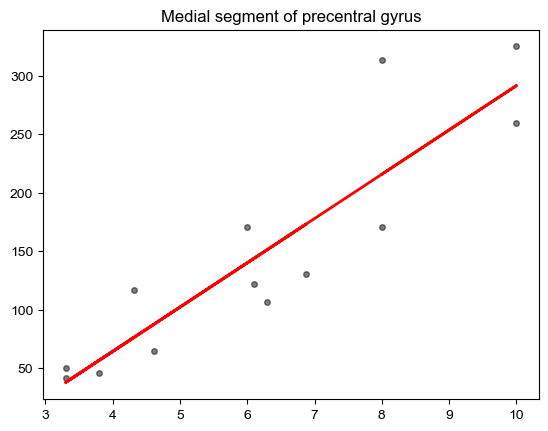

LinregressResult(slope=24.34492896625597, intercept=-2.776373781472813, rvalue=0.8078175799862753, pvalue=0.00026951345203999976, stderr=4.926717574585836, intercept_stderr=32.75137181053212)


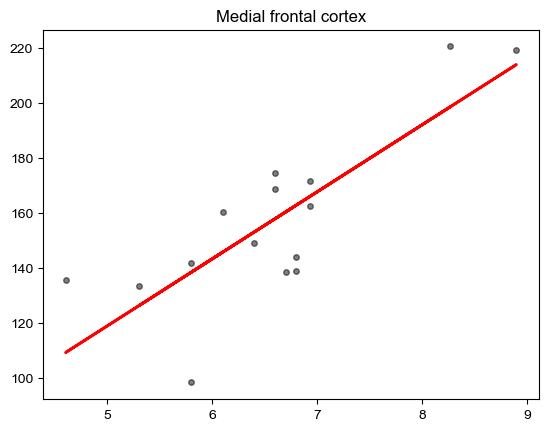

LinregressResult(slope=37.35115320480607, intercept=-96.76317497158908, rvalue=0.8309305808004971, pvalue=1.773362921126079e-11, stderr=4.004750262415122, intercept_stderr=25.44709761654576)


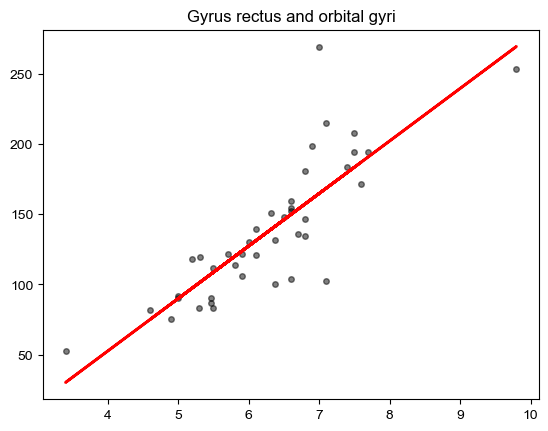

LinregressResult(slope=22.00132763262901, intercept=-13.071801115757381, rvalue=0.7894055424020782, pvalue=0.00016449008021070398, stderr=4.417544624859916, intercept_stderr=26.415329486371384)


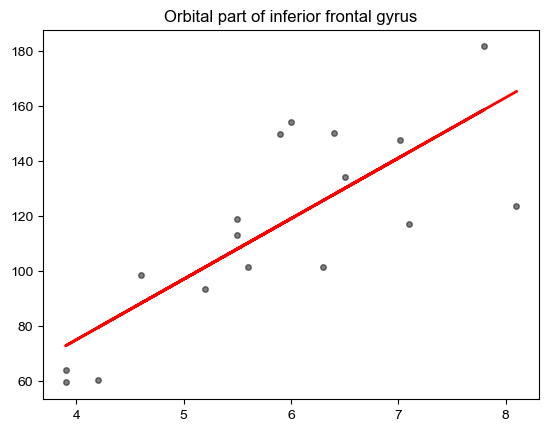

LinregressResult(slope=12.740372859421232, intercept=91.27044683265493, rvalue=0.24941597385379985, pvalue=0.3515553930005495, stderr=13.220474469025216, intercept_stderr=85.06844324328455)


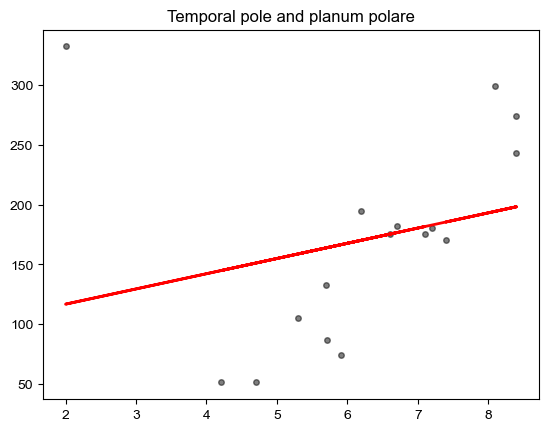

LinregressResult(slope=11.347296342749353, intercept=59.160956186822794, rvalue=0.20717815070862128, pvalue=0.2719791928774217, stderr=10.126116448315425, intercept_stderr=49.724366369784896)


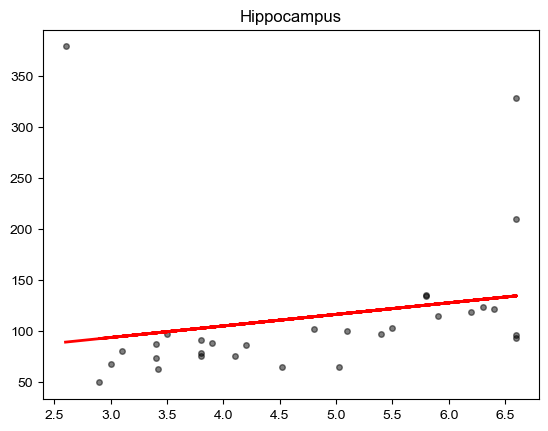

LinregressResult(slope=24.19794537674444, intercept=-32.69479416796078, rvalue=0.942486531895098, pvalue=4.497869123430192e-06, stderr=2.713733061283663, intercept_stderr=14.97663345957171)


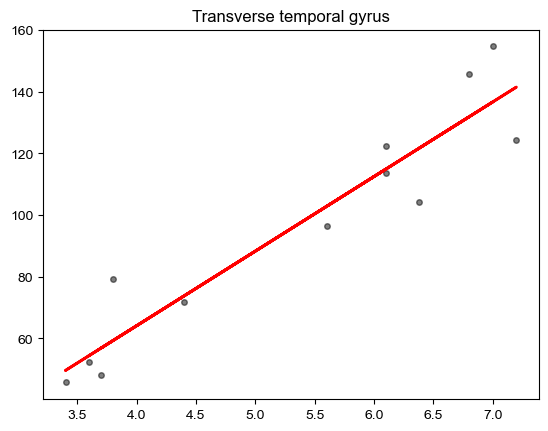

LinregressResult(slope=26.4636185820913, intercept=-15.430181173151283, rvalue=0.5707061027067435, pvalue=9.772616328965989e-05, stderr=6.097183016990395, intercept_stderr=35.96477405731593)


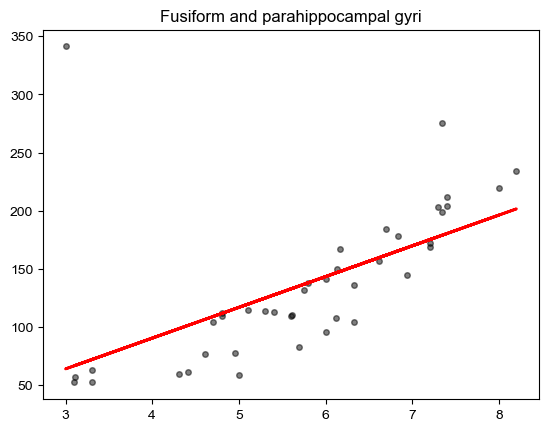

LinregressResult(slope=44.63510239539923, intercept=-134.79500732943876, rvalue=0.8784707436170571, pvalue=9.408637103859611e-14, stderr=3.9382209004587887, intercept_stderr=23.598285923771556)


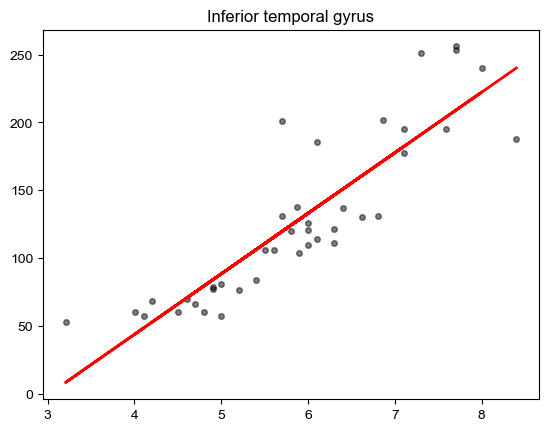

LinregressResult(slope=52.08226354645702, intercept=-161.8954796186389, rvalue=0.6591971671820328, pvalue=1.1516148112202072e-15, stderr=5.589022957502065, intercept_stderr=36.08780924989187)


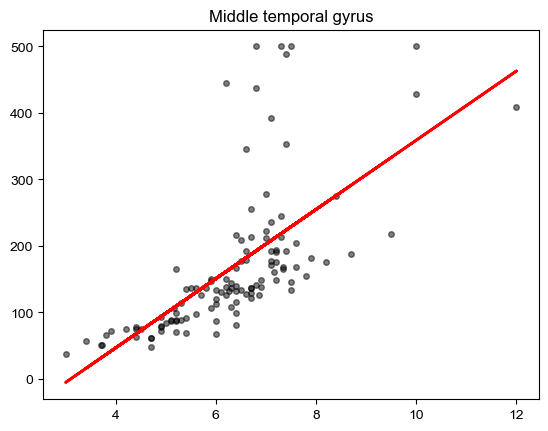

LinregressResult(slope=40.14434386981329, intercept=-112.43025480189843, rvalue=0.8031183196225334, pvalue=1.0275245979923704e-16, stderr=3.6384984713436785, intercept_stderr=23.854294844490905)


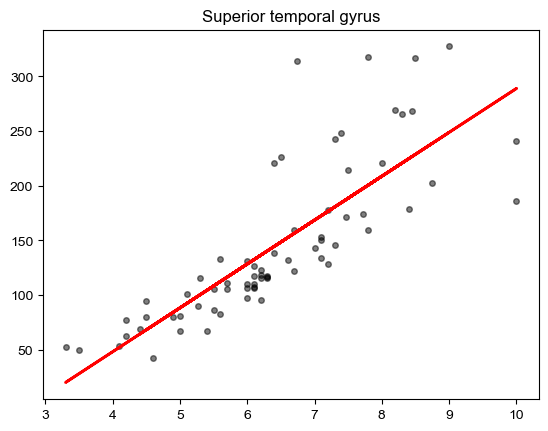

LinregressResult(slope=36.333496499401306, intercept=-99.25872836127053, rvalue=0.454979049249447, pvalue=0.013143223868751308, stderr=13.685758780313787, intercept_stderr=88.89578849764254)


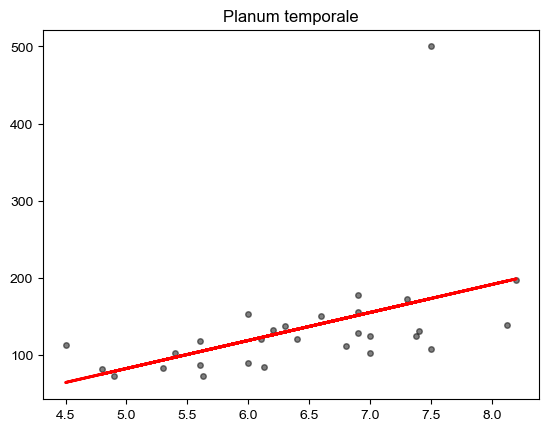

LinregressResult(slope=26.122158994570693, intercept=-32.6238483319229, rvalue=0.9302566576363392, pvalue=0.007126580231482771, stderr=5.151517669618611, intercept_stderr=30.641788321635147)


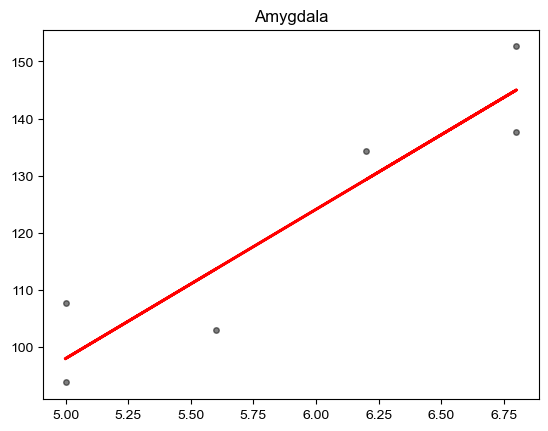

In [35]:
from scipy import stats


def _check_corr(x, y, title=""):
    res = stats.linregress(x, y)
    print(res)

    plt.plot(x, y, "ko", ms=4, alpha=0.5)
    plt.plot(x, res.intercept + res.slope * x, "r", lw=2)
    plt.title(title)
    plt.show()


# Print and plot for all areas
_check_corr(
    df_sw_n3_all["total"].to_numpy().squeeze(),
    df_tau_n3_all["tau"].to_numpy().squeeze(),
    title="All areas",
)

# Print and plot for each MNI area
for reg in df_tau_n3_all["region"].unique():
    _check_corr(
        df_sw_n3_all.loc[df_tau_n3_all["region"] == reg, "total"].to_numpy().squeeze(),
        df_tau_n3_all.loc[df_tau_n3_all["region"] == reg, "tau"].to_numpy().squeeze(),
        title=reg,
    )

Generally, all areas display the same positive realtionship!

For gamma:

LinregressResult(slope=3.9730048442079813, intercept=19.413240443104858, rvalue=0.13793066623059688, pvalue=1.1229143970875232e-07, stderr=0.7451097981075355, intercept_stderr=4.716949691141311)


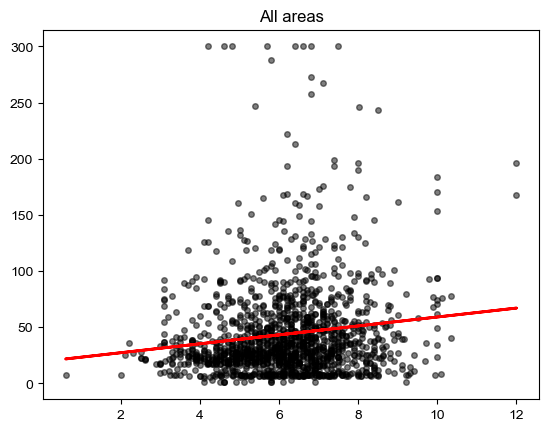

LinregressResult(slope=12.413853367789244, intercept=12.00431919688667, rvalue=0.35697233323245015, pvalue=0.11216454192204839, stderr=7.452390078602826, intercept_stderr=35.425990298448035)


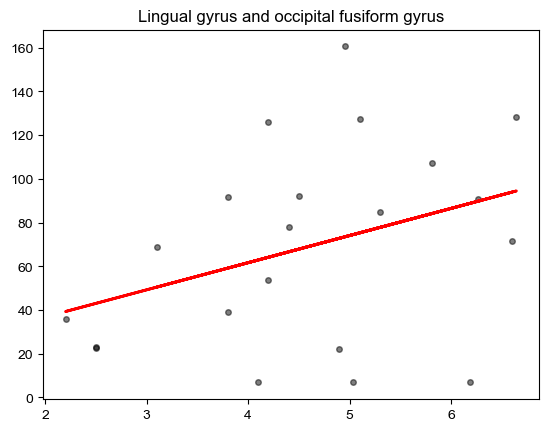

LinregressResult(slope=-7.41247905499322, intercept=110.26349015000947, rvalue=-0.18026485166703274, pvalue=0.42210697451480494, stderr=9.04407054748055, intercept_stderr=49.524277212921156)


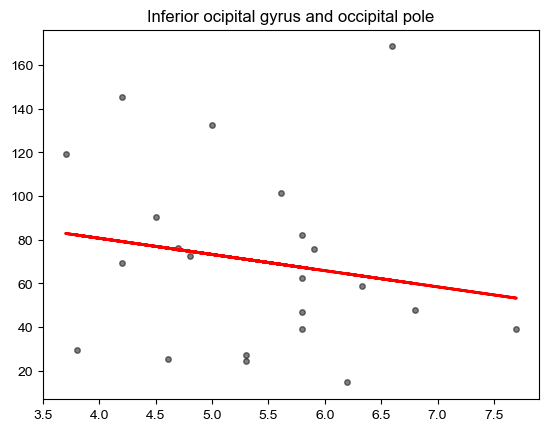

LinregressResult(slope=69.66964498579429, intercept=-190.28504291216498, rvalue=0.7024492143025857, pvalue=0.02350278888323348, stderr=24.95751301770886, intercept_stderr=95.41149836296148)


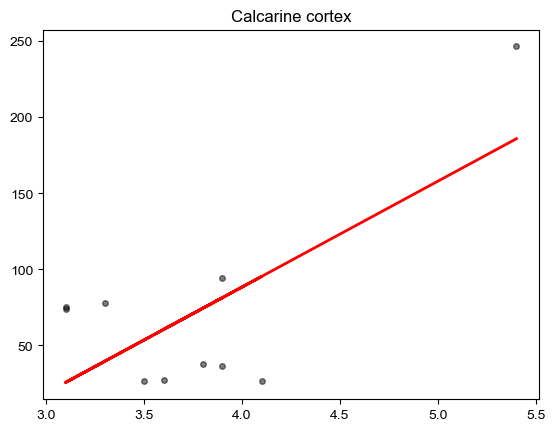

LinregressResult(slope=-10.297944970472031, intercept=143.60138794011633, rvalue=-0.16547134878660158, pvalue=0.5402462798531416, stderr=16.403448843074845, intercept_stderr=98.52316127262411)


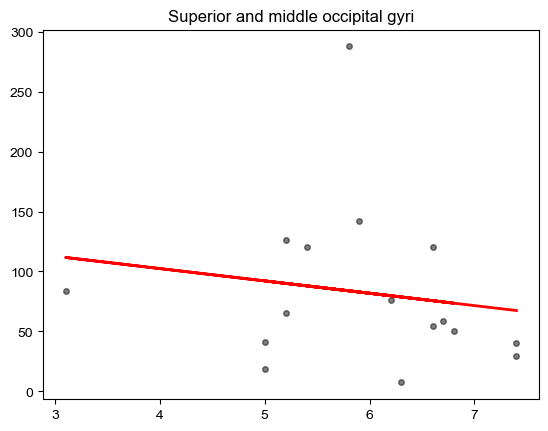

LinregressResult(slope=-16.180310887755518, intercept=131.4786443967197, rvalue=-0.41887717212070774, pvalue=0.08360074840768267, stderr=8.76892885113116, intercept_stderr=39.38757992927618)


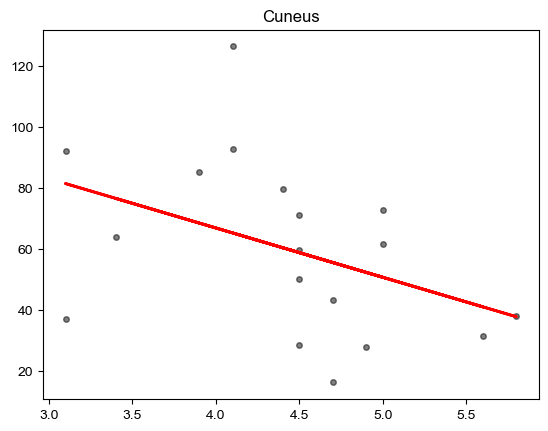

LinregressResult(slope=4.689802013989546, intercept=12.693983488488296, rvalue=0.34041118476128296, pvalue=0.03924630089908048, stderr=2.189638035067127, intercept_stderr=13.990752781169403)


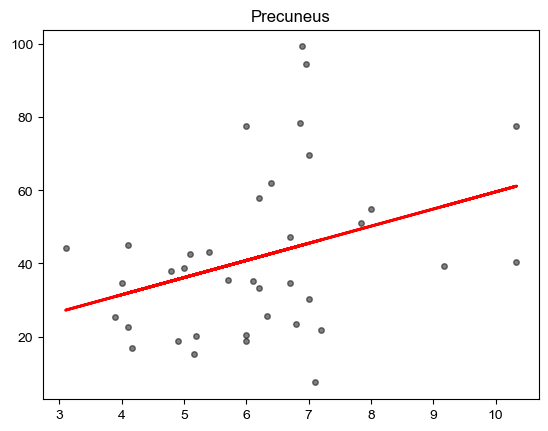

LinregressResult(slope=-0.9443586135689396, intercept=55.08788154603065, rvalue=-0.03703563136255067, pvalue=0.7943508751530167, stderr=3.603579761996841, intercept_stderr=25.390608164992155)


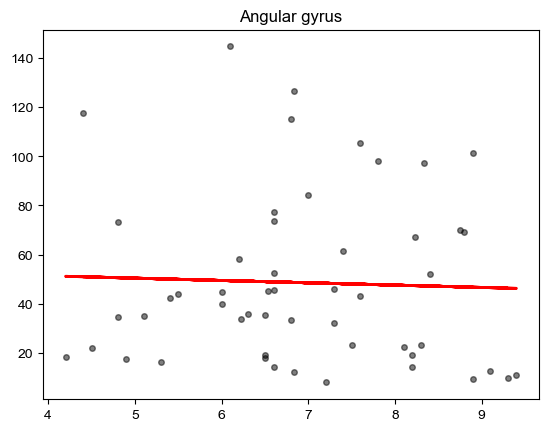

LinregressResult(slope=8.238975361059952, intercept=-24.959197149639127, rvalue=0.5208726389781984, pvalue=0.002661760985905466, stderr=2.5073477407092186, intercept_stderr=16.711476269175737)


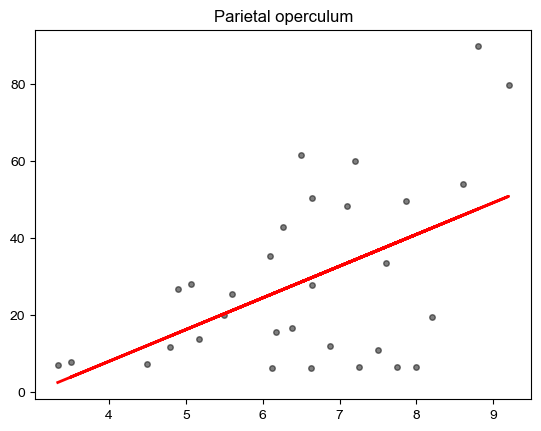

LinregressResult(slope=11.270756145362684, intercept=-24.06573528820958, rvalue=0.3623445601729162, pvalue=0.01694910635142535, stderr=4.527681772034357, intercept_stderr=32.08955221790241)


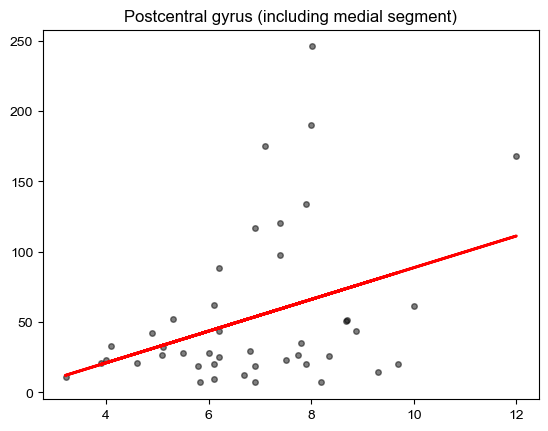

LinregressResult(slope=7.820897173678229, intercept=-4.131231414725399, rvalue=0.25581564460694806, pvalue=0.11110299092681891, stderr=4.794473135803415, intercept_stderr=31.510987876292152)


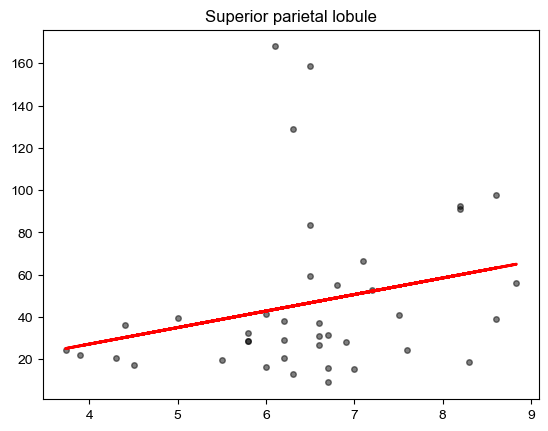

LinregressResult(slope=1.2705473025125256, intercept=38.50476477207874, rvalue=0.02789607905271542, pvalue=0.8254160658254788, stderr=5.735989541534098, intercept_stderr=37.20526781804574)


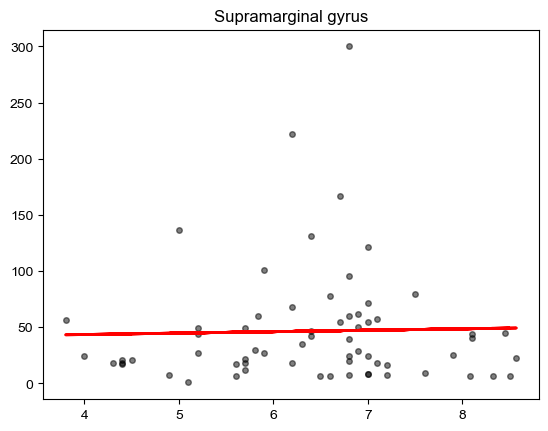

LinregressResult(slope=7.51776595172062, intercept=0.5651879412413336, rvalue=0.2931031136612765, pvalue=0.15504392396931932, stderr=5.113273981611676, intercept_stderr=31.024286767897017)


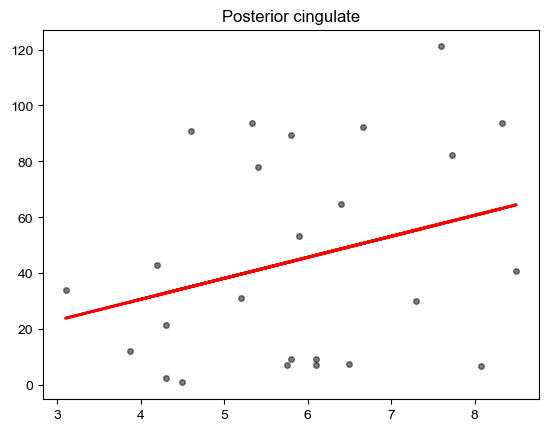

LinregressResult(slope=3.4072116524676774, intercept=1.4262608920325803, rvalue=0.2878236276735603, pvalue=0.0348188758721149, stderr=1.5721463539024296, intercept_stderr=10.755445341107478)


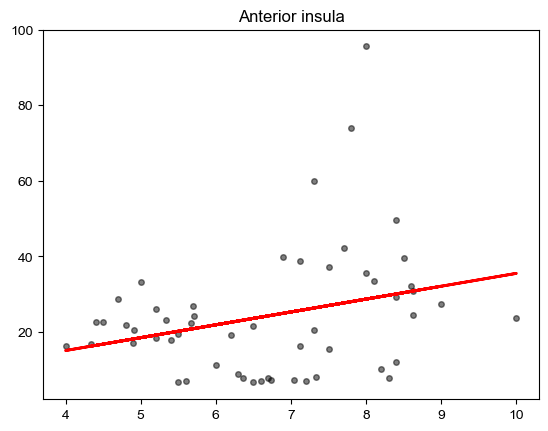

LinregressResult(slope=10.41590783971363, intercept=-34.61879643183406, rvalue=0.6519434813206799, pvalue=0.00041395522221874067, stderr=2.5260720966175976, intercept_stderr=17.05475586313039)


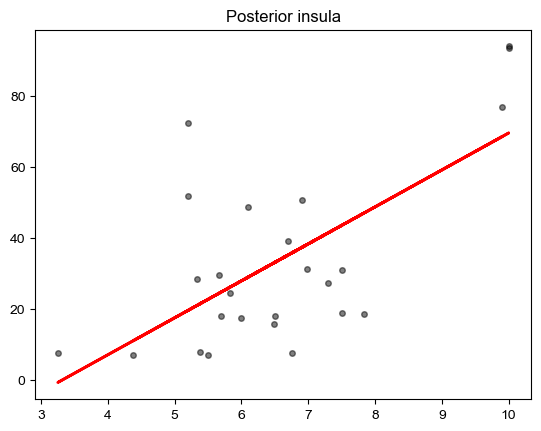

LinregressResult(slope=-5.91169228488243, intercept=64.00758145385002, rvalue=-0.14540766607823571, pvalue=0.4351039280429658, stderr=7.46938863520819, intercept_stderr=42.194542149744244)


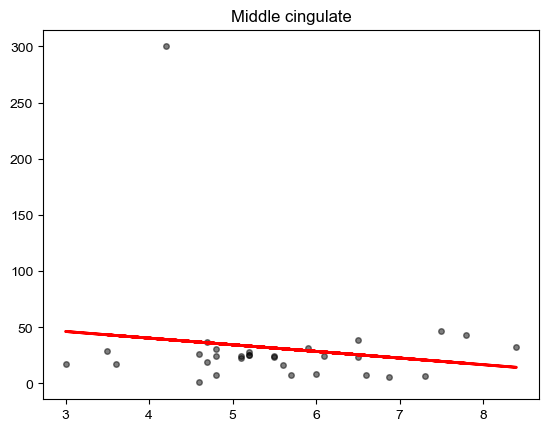

LinregressResult(slope=1.3057842559436599, intercept=23.228971852019264, rvalue=0.09278494298698417, pvalue=0.40705050455056857, stderr=1.5666479156087723, intercept_stderr=9.62006271272062)


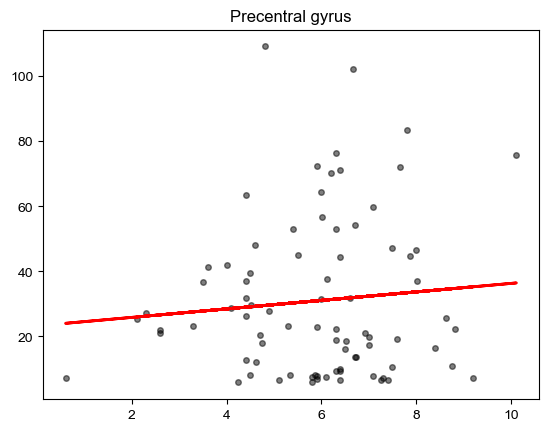

LinregressResult(slope=3.4138695520366262, intercept=14.307436114218302, rvalue=0.12964164848992174, pvalue=0.4444209048853448, stderr=4.413546978706064, intercept_stderr=25.837729584696135)


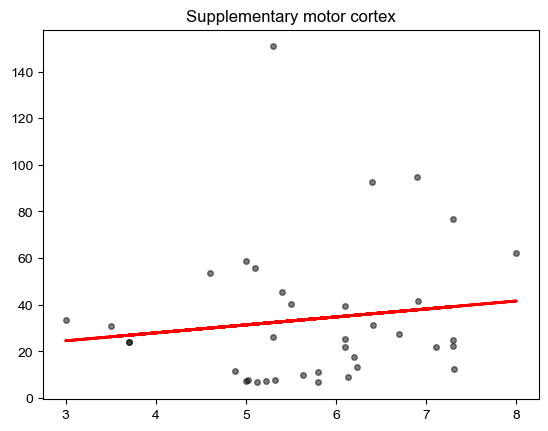

LinregressResult(slope=4.942530270557467, intercept=-1.6430305683367905, rvalue=0.14307774281257377, pvalue=0.34283069222397766, stderr=5.1541792154889965, intercept_stderr=32.89667773522262)


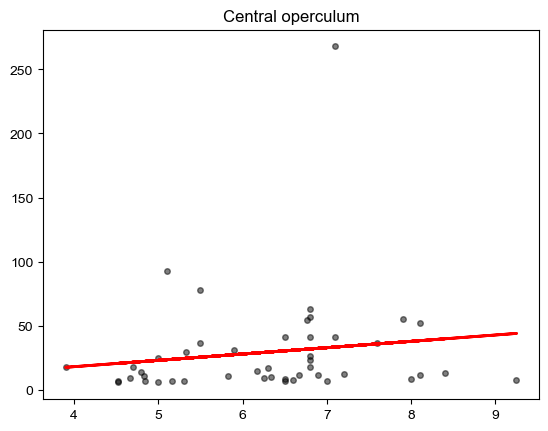

LinregressResult(slope=9.226379024784054, intercept=-23.229811662183124, rvalue=0.2898884913866141, pvalue=0.1202086315300139, stderr=5.756528530443422, intercept_stderr=40.0940920967185)


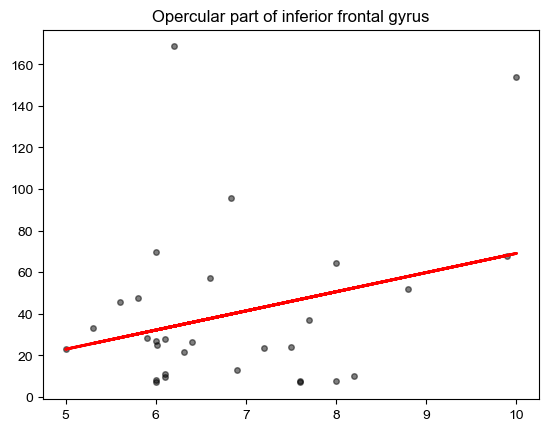

LinregressResult(slope=4.8140337211149635, intercept=11.091067787695088, rvalue=0.13355885681627613, pvalue=0.5338297642166301, stderr=7.615819899112233, intercept_stderr=55.53955731873428)


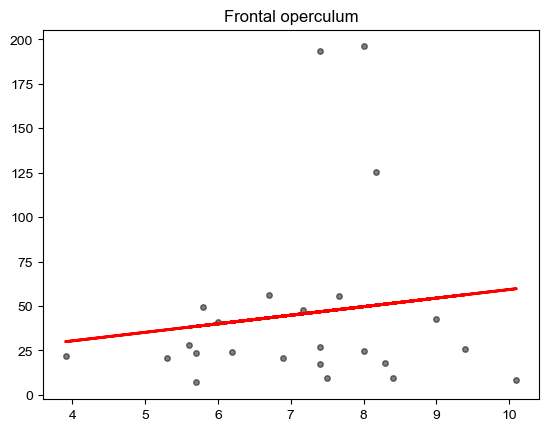

LinregressResult(slope=5.3583583266372345, intercept=31.34833532370496, rvalue=0.11510478554707171, pvalue=0.47360578254901975, stderr=7.404740309551613, intercept_stderr=46.217604274823486)


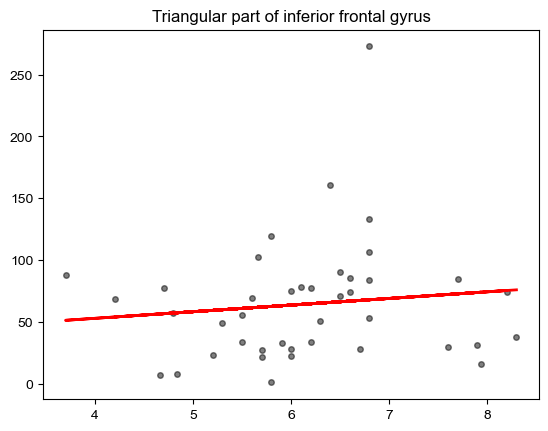

LinregressResult(slope=-0.17936030396377586, intercept=46.61478985772119, rvalue=-0.008273825918538768, pvalue=0.9202283638721536, stderr=1.7879131524856193, intercept_stderr=11.54647580997948)


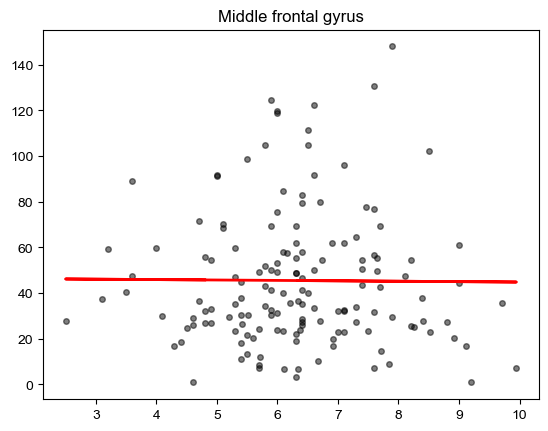

LinregressResult(slope=0.6927358254718532, intercept=29.20019055363789, rvalue=0.016316295942668688, pvalue=0.9305779583759299, stderr=7.882958829248924, intercept_stderr=43.74143263969699)


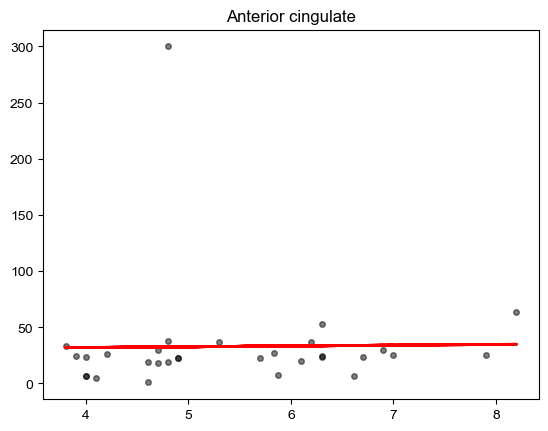

LinregressResult(slope=13.066541451132576, intercept=-43.72156127080724, rvalue=0.4206941217011524, pvalue=0.10467097827838516, stderr=7.530684418370317, intercept_stderr=49.53667481611699)


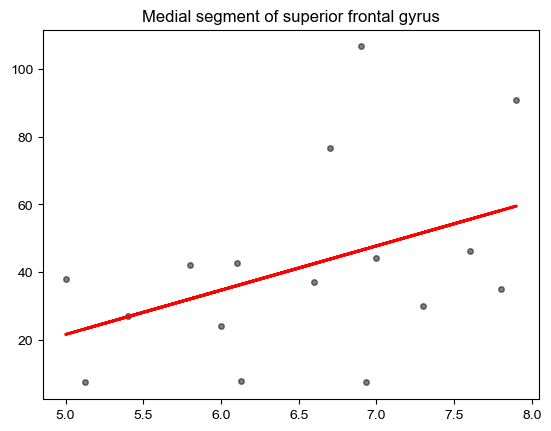

LinregressResult(slope=-6.089151138487877, intercept=81.71039035801171, rvalue=-0.18631883744139557, pvalue=0.10240745238800116, stderr=3.683163822329567, intercept_stderr=23.656258289946145)


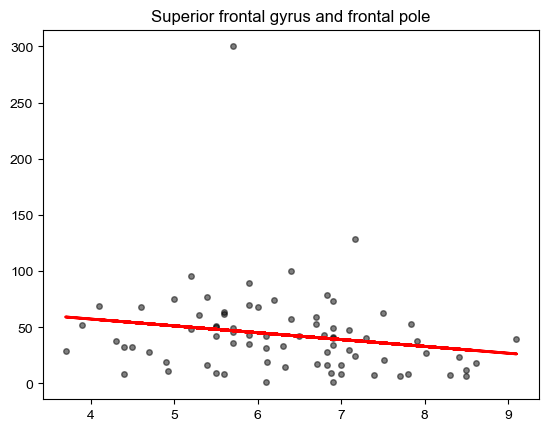

LinregressResult(slope=16.88390893085431, intercept=-53.596897058868, rvalue=0.7278401560337645, pvalue=0.004796685878327306, stderr=4.7962791419778945, intercept_stderr=31.60086478242202)


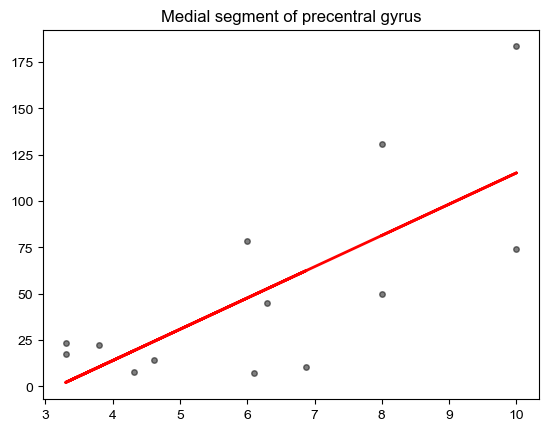

LinregressResult(slope=-28.92433481479989, intercept=241.99362861253778, rvalue=-0.4382177239798056, pvalue=0.10229041621181316, stderr=16.455008082330608, intercept_stderr=109.38806206991183)


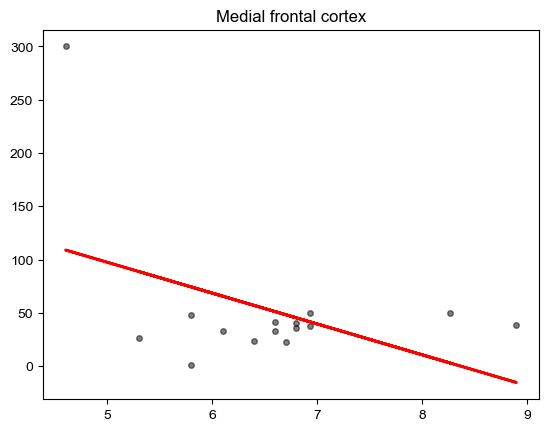

LinregressResult(slope=10.562760376362679, intercept=-19.31721478640049, rvalue=0.23934130207974974, pvalue=0.13177486086856435, stderr=6.861480827327731, intercept_stderr=43.59941593505709)


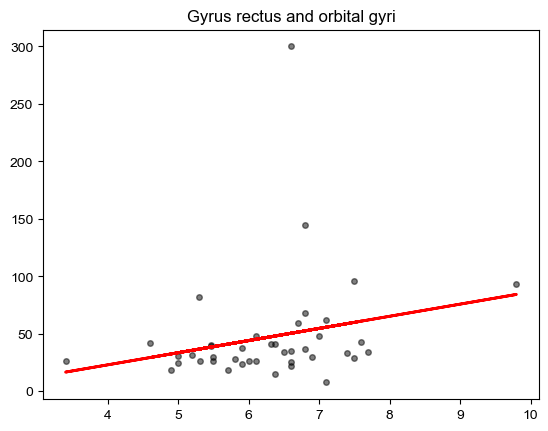

LinregressResult(slope=5.993683842208944, intercept=2.7816701046682084, rvalue=0.47200604691449105, pvalue=0.05575213041609886, stderr=2.8904796108688604, intercept_stderr=17.28402942780928)


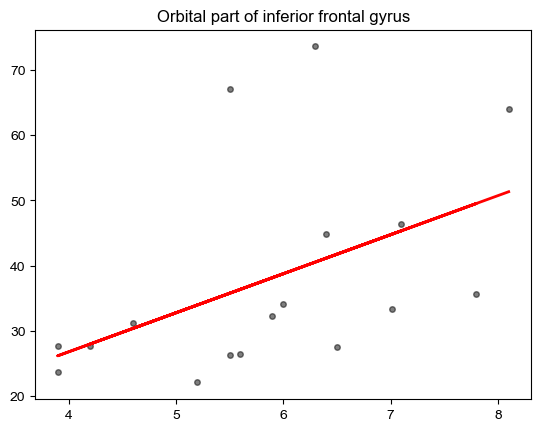

LinregressResult(slope=8.495807175483439, intercept=-11.54107890091398, rvalue=0.3776332663637963, pvalue=0.14928940117319278, stderr=5.567501980191181, intercept_stderr=35.824639071648164)


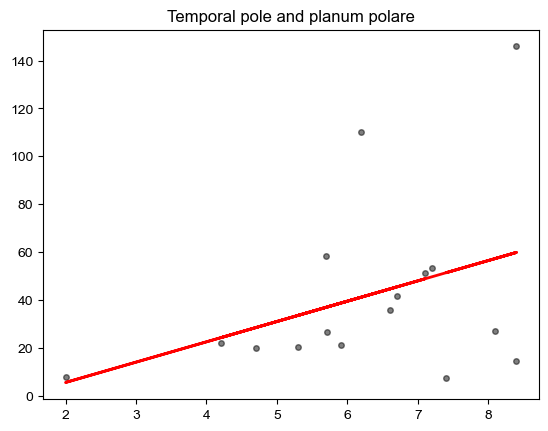

LinregressResult(slope=1.974668195064175, intercept=12.529338673506992, rvalue=0.18341999553369684, pvalue=0.3319425129518905, stderr=2.0000334499450334, intercept_stderr=9.821178388032086)


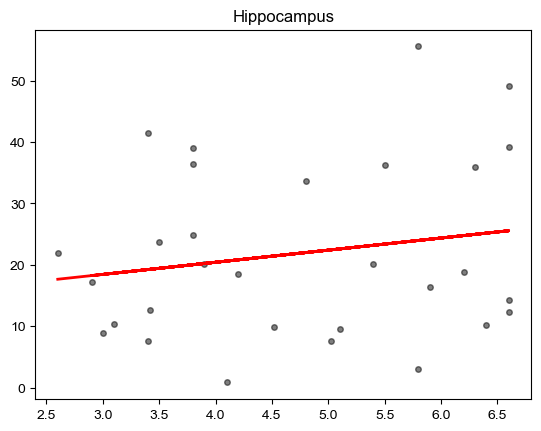

LinregressResult(slope=0.06803445635516084, intercept=24.69576971395393, rvalue=0.008955070255271905, pvalue=0.9779644880089475, stderr=2.402384443701133, intercept_stderr=13.258353135613751)


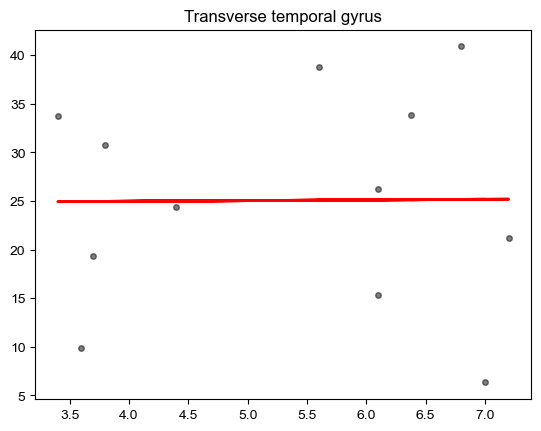

LinregressResult(slope=9.192921640807098, intercept=-10.725609054231668, rvalue=0.4392396569648653, pvalue=0.004064088910762696, stderr=3.0107515317383755, intercept_stderr=17.759184574245673)


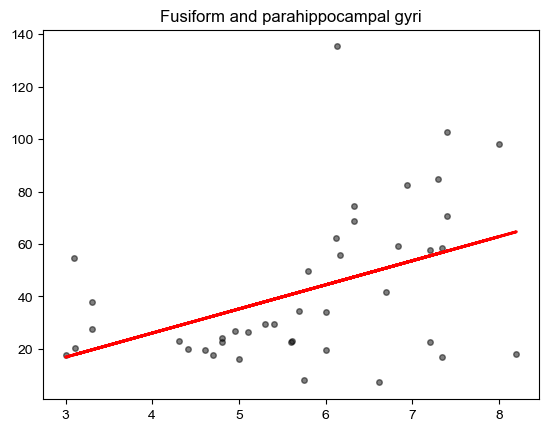

LinregressResult(slope=-3.1530546935997936, intercept=57.384297331168085, rvalue=-0.13049242560038693, pvalue=0.42221954647487514, stderr=3.8861979218554916, intercept_stderr=23.28655807642205)


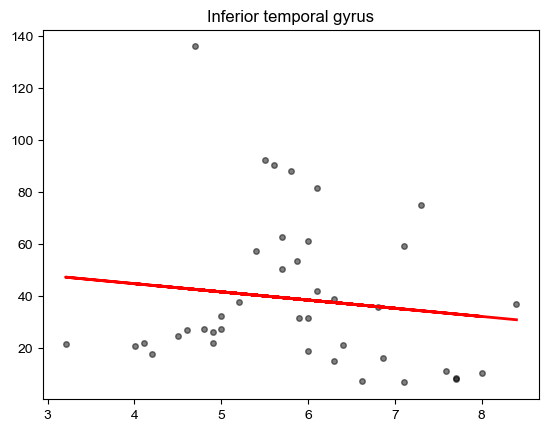

LinregressResult(slope=12.764983754288243, intercept=-33.09487534579975, rvalue=0.4049196270448743, pvalue=7.167931050607896e-06, stderr=2.7116009016474663, intercept_stderr=17.508558623674684)


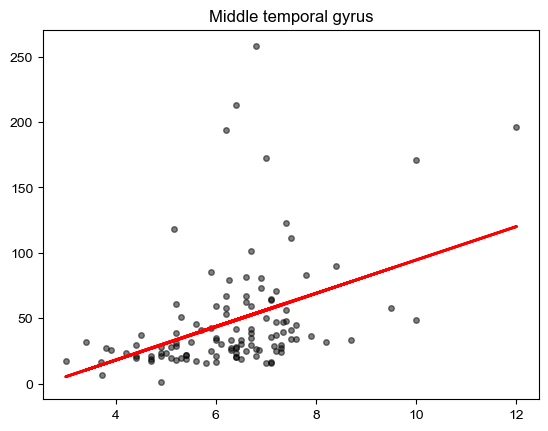

LinregressResult(slope=14.563260593797096, intercept=-36.43699050150213, rvalue=0.363721118045296, pvalue=0.0021258871813258956, stderr=4.556582518449352, intercept_stderr=29.87332926876388)


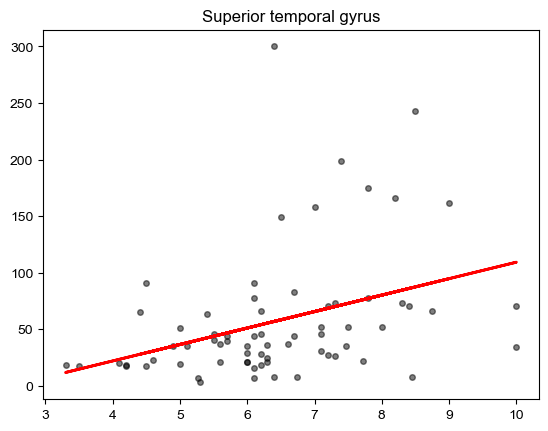

LinregressResult(slope=-1.9934243928057287, intercept=66.22841774855424, rvalue=-0.0316560625527324, pvalue=0.8705066031843556, stderr=12.112764595088978, intercept_stderr=78.67841139474433)


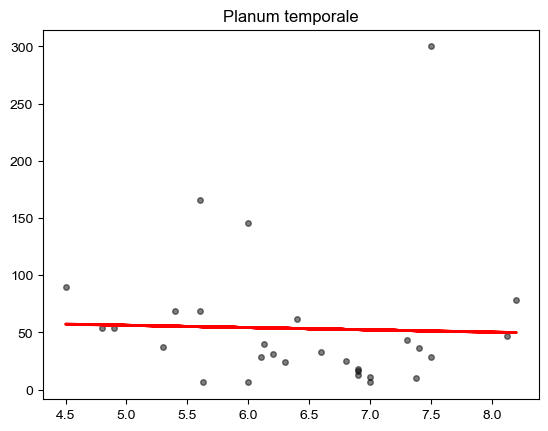

LinregressResult(slope=1.7495219156057185, intercept=26.415087684788237, rvalue=0.12649923064761812, pvalue=0.8112632778741313, stderr=6.8595970180386265, intercept_stderr=40.801630369642226)


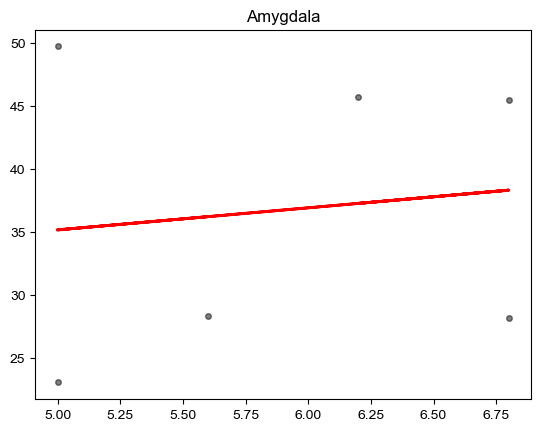

In [37]:
# Print and plot for all areas
_check_corr(
    df_sw_n3_all["total"].to_numpy().squeeze(),
    df_tau_gamma_n3_all["tau"].to_numpy().squeeze(),
    title="All areas",
)

# Print and plot for each MNI area
for reg in df_tau_gamma_n3_all["region"].unique():
    _check_corr(
        df_sw_n3_all.loc[df_tau_gamma_n3_all["region"] == reg, "total"]
        .to_numpy()
        .squeeze(),
        df_tau_gamma_n3_all.loc[df_tau_gamma_n3_all["region"] == reg, "tau"]
        .to_numpy()
        .squeeze(),
        title=reg,
    )

Here instead, for most regions there is simply no relationship, although it seems always to to be pointing towards positive.

### S4) N2 sleep

Generating 1000 permutations...
Generating 1000 permutations...


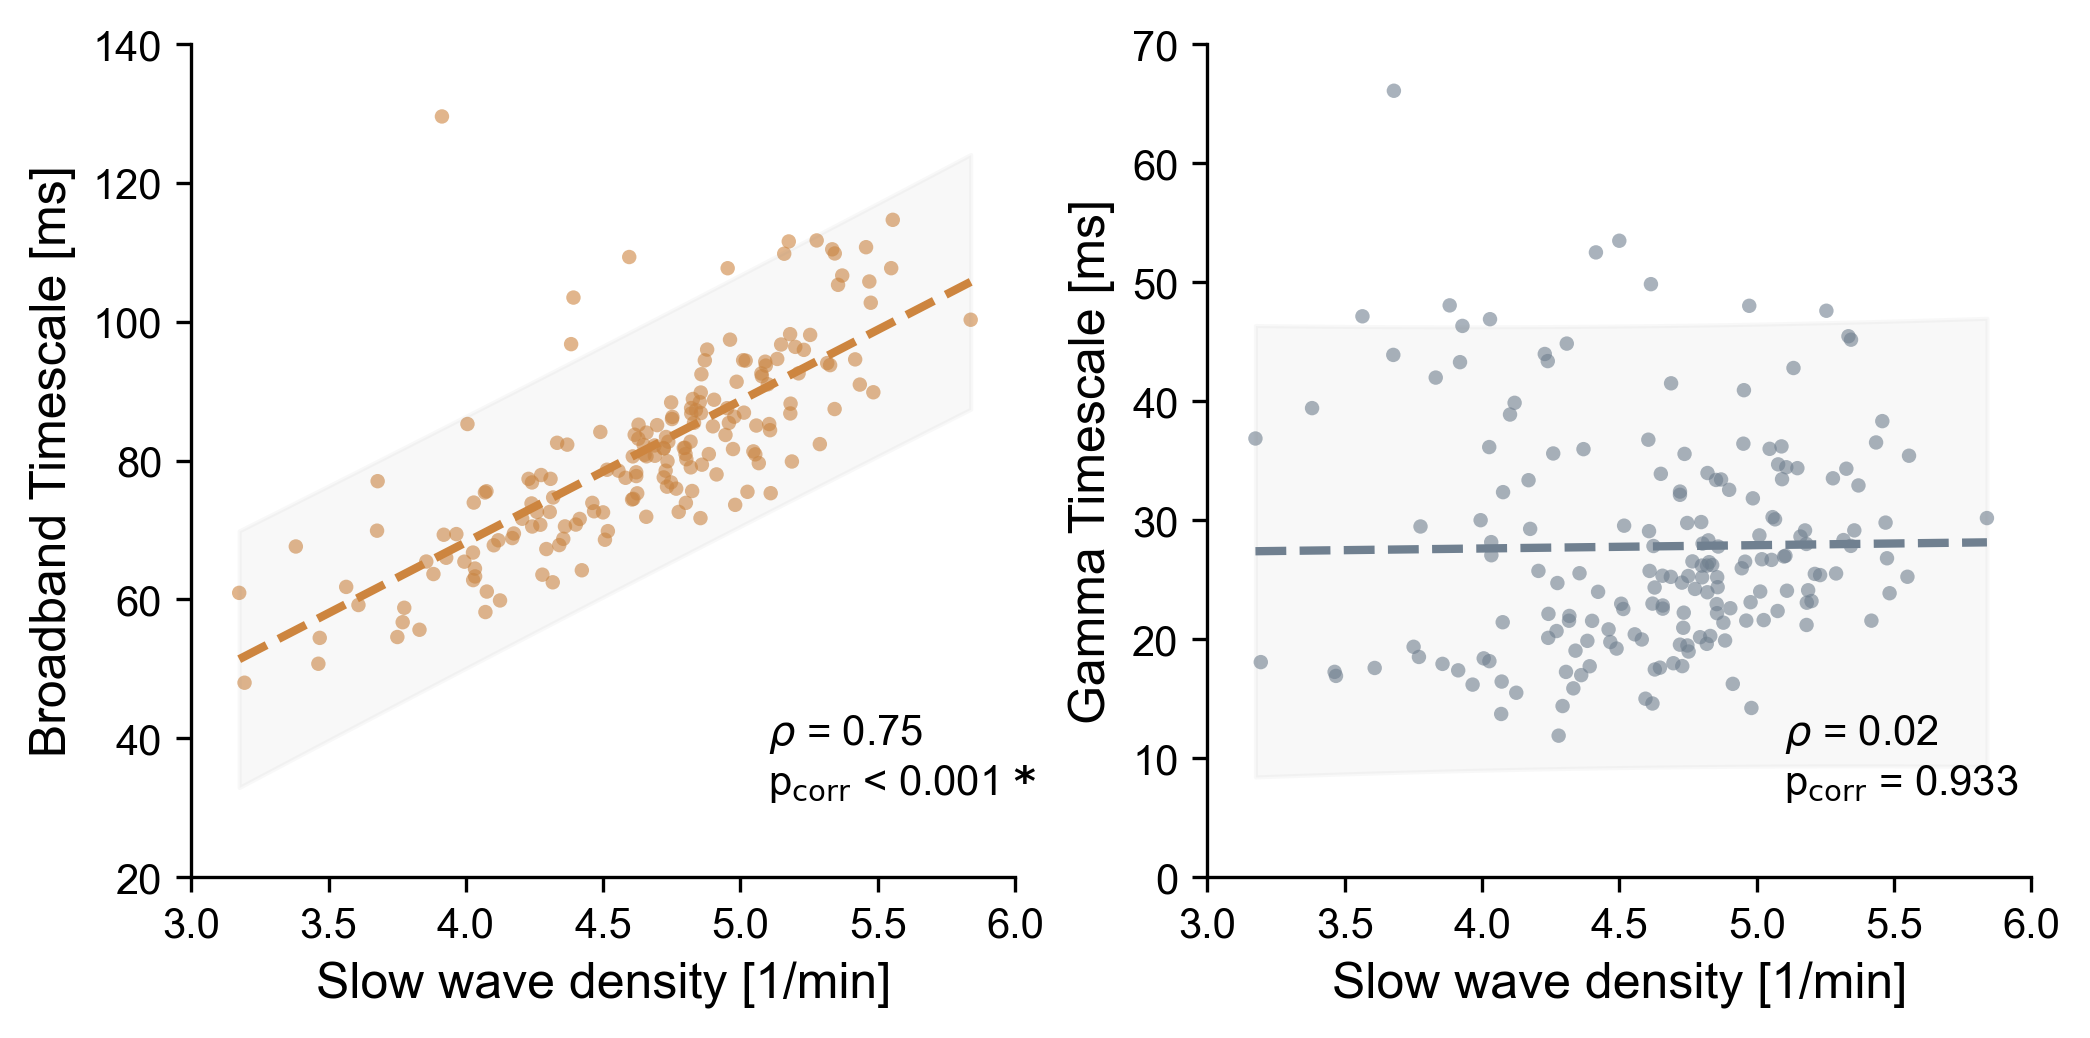

In [39]:
xlabels = {
    "total": "Slow wave density [1/min]",
}

xlims_stages = {
    "total": {"N2": (3.0, 6.0), "N3": (4, 8)},
}
# ylims_stages = {"N2": (20, 140), "N3": (60, 200)}

colors = ["peru", "slategrey"]
ylabels = ["Broadband Timescale [ms]", "Gamma Timescale [ms]"]
ylims = ((20, 140), (0, 70))


for cond, df_metric in zip(
    ["total"],  # , "local", "global"],
    [df_density_stages],  # , df_density_stages_local, df_density_stages_global],
):

    fig, axs = plt.subplots(
        1,
        2,
        figsize=plots._get_figsize_inches((17.4, 8.5)),
        dpi=300,
        layout="constrained",
    )
    if not isinstance(axs, np.ndarray):
        axs = np.array(axs).reshape(
            1,
        )

    # rhos, p_corrs, rhos_boot = {}, {}, {}

    for i, df_timescales in enumerate(
        [df_timescales_stages["N2"], df_timescales_stages_gamma["N2"]]
    ):
        # Import dataframe
        df_tau = df_timescales.copy()
        df_sw = df_metric["N2"].copy()

        # Get data
        x = df_sw.to_numpy().squeeze()
        y = df_tau.loc[df_sw.index].to_numpy().squeeze()

        # Get correlation values
        rho, p_corr = utils.get_pcorr(
            x, y, map_coords, method="vasa", corr_type=corr_type
        )
        rho_boot = utils.get_rho_boot(x, y, corr_type=corr_type)

        # Plot
        axs[i] = plots.plot_corr(
            axs[i],
            x,
            y,
            rho,
            p_corr,
            markersize=12,
            xy_annot=(0.7, 0.1),
            color=colors[i],
            xlabel=xlabels[cond],
            ylabel=ylabels[i],
            xlims=xlims_stages[cond]["N2"],
            ylims=ylims[i],
        )

    # Save figure
    # plots.save_figure(fig, fig_path.joinpath(f"sw_tau_corr_{cond}.svg"))

    plt.show()